# Intro

We are Roman (313597270) and Or (315339960), and in this notebook, we are going to talk about data from 911 calls.
We have looked far and wide for a dataset that has enough "meat" for a nice EDA, in a field that is interesting to us, and where we believed we could train an interesing model.
Our research has led us to this [Kaggle Dataset](https://www.kaggle.com/datasets/louisteitelbaum/911-recordings-first-6-seconds).

## About 911
The 911 hotline, a pivotal component of emergency response systems in the United States and various other countries, is a three-digit phone number primarily designed for immediate access to emergency services.
Established in 1968, the 911 hotline has evolved to become a critical lifeline, connecting individuals in distress with swift assistance from law enforcement, fire departments, and medical professionals.
Its importance cannot be overstated, as it serves as the first point of contact in times of crisis, enabling efficient coordination of resources and reducing response times.
Its historical significance, coupled with its ever-increasing relevance in the digital age, underscores the importance of continually optimizing and leveraging data-driven approaches to ensure the safety and well-being of communities.

## About the dataset
Our main dataset (linked above) contains the first 6 seconds of a collection of usunsual or critical calls, we also have the [full audio version](https://www.kaggle.com/datasets/louisteitelbaum/911-recordings) of these calls available, which we might incorporate in a later stage if needed, but for the time being when we refer to "The Dataset" we are specifically referring to the 6-second dataset.
The dataset also has a .csv table which includes features like title, state, number of casualities, was this call a false alarm etc, The dataset consists of around 700 calls, including full audio of the calls.
While invasive, and at times very difficult to go through, the subject matter was both interesting and important, as using data science to improve upon the existing system of the 911 hotline could help to save lives.
While not the largest 911 call sample, the availability of the original voice recordings drew us to analyze this dataset, because:
1. Using voice recordings increased the range of applications that we could think of to include real-time audio processing, for example have an active assistant that could highlight whether or not this call sounds dangerous.
2. We were interested in analyzing audio data as part of this project.

We didn't start with a clear model in mind, and first went to analyze what we can and can't do with the data.
Right off the bat however, we saw some difficulties in trying to apply what we do here to real-life situations:
- The dataset is not very large, consisting of only 700 calls.
- The dataest is hand selected by a senior operator to train new 911 operators.

Therefore, this dataset is skewed towards irregular calls, so using this data to correctly make predictions about random 911 calls could lead to bad results, and be skewed towards making false positives.
However, we hope the work we do here can provide a good proof of concept that could perhaps be extended upon with access to a larger dataset.

## The Problem
911 gets around 657,000 calls, every single day in the US.
This means thousands upon thousands of operators are needed, and they must perform flawlessly for hunderds of calls each and every day, with the extreme pressure that if they make a mistake - it could cost someone's life.
Right now the operator has to sift through all of those calls, and try to understand if every one of the callers is in real danger or not.
Also, in many instances, the caller who is in danger might not want to reveal he is talking to 911, so he could be talking in code.
The operator must differentiate between those who are in danger, to those who mixed up 911 with Domino's number.
We propose to make a model that can help the operator - by analyzing the call in real time, it can try to make suggestions, to determine whether or not the caller is in danger, or maybe even if the call is a false alarm.

# Notebook Setup
Let's keep the imports and setup here:

In [2]:
# Some installtions here:
!pip3 install -r ./requirements.txt --quiet --upgrade


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
# Imports and setup
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from matplotlib.dates import YearLocator, DateFormatter
import itertools
import random
import warnings
from pprint import pprint

warnings.filterwarnings('ignore')

sns.set_palette("pastel")
palette = itertools.cycle(sns.color_palette())
random.seed(42)

# define cwd based on environment
is_drive = False
cwd_plain = os.getcwd()
cwd_drive = os.path.join(cwd_plain, 'drive', 'MyDrive', 'project')
cwd = cwd_drive if is_drive else cwd_plain

# directories
gen_data_dir = os.path.join(cwd, 'data')
calls_dir = os.path.join(gen_data_dir, 'calls')
metadata_path = os.path.join(calls_dir, '911_first6sec', '911_metadata_6sec.csv')

# function defs
def get_path_from_filename(audio_file_name):
    type_dir, file_name = audio_file_name.split('/')
    return os.path.join(calls_dir, type_dir, file_name)

# EDA - CSV

First off, let's have a look at a sample of our CSV data, so we can see the different columns that we have and examples of what they contain:

In [4]:
# load the dataset
df = pd.read_csv('911_metadata.csv')
print(f"total rows: {len(df)}")

total rows: 710


In this ~700 rows dataset, we have the following information:
1. event_id - arbitrarily given by the dataset's original collector, we can see that they are non-liner (1 is missing for example) this is because this dataset was curated from the full audio dataset, linked above, to include "only civilian-initiated 911 calls".
2. link - link to the web archive containig the source of the call.
3. date - date of the phone call.
4. state - which US state (or canada) the call was made in.
5. deaths - number of deaths in the event (if none then 0)
6. deaths_binary - 1 if at least 1 death occurred, 0 otherwise.
7. break - represents the offset in seconds from the beggining of the audio where the call actually starts (i.e. ignoring "9-1-1 what's your emergency", and such), there are some exceptions to this that will be explored and elaborated on furthered along.
8. filename - name of the file as saved in the dataset.
9. potential_death, false_alarm, description & title - as definined by the collector.

## Cleaning the data

#### Duplications

Let's start by trying to deduplicate by the id field:

In [5]:
df_clean = df.drop_duplicates(subset=['id'])
print(f"total dataset count after deduplication: {len(df_clean)}")

total dataset count after deduplication: 710


It appears there are no duplications - we can set the ids to be the keys for the dataset:

In [6]:
df_clean = df.set_index('id')

Let us check if every filename in the csv is unique:

In [7]:
df_clean['filename'].value_counts()

filename
911_first6sec/call_389_0.wav    4
911_first6sec/call_2_0.wav      1
911_first6sec/call_517_0.wav    1
911_first6sec/call_505_0.wav    1
911_first6sec/call_507_0.wav    1
                               ..
911_first6sec/call_258_0.wav    1
911_first6sec/call_261_0.wav    1
911_first6sec/call_262_0.wav    1
911_first6sec/call_263_0.wav    1
911_first6sec/call_743_0.wav    1
Name: count, Length: 707, dtype: int64

Thats odd, seems that exactly 1 file is duplicated 4 times, let's take a look:

In [8]:
df_clean[df_clean['filename'] == '911_first6sec/call_389_0.wav']

,event_id,link,title,date,state,deaths,potential_death,false_alarm,description,deaths_binary,break,filename
id,,,,,,,,,,,,
362,389,https://web.archive.org/web/20150417085338/htt...,Non-emergency call,8/08,Florida,0.0,0.0,1.0,NaN,0,12.0,911_first6sec/call_389_0.wav
363,389,https://web.archive.org/web/20150417085338/htt...,Delayed response,8/08,Florida,1.0,1.0,0.0,"– In August, 2008 a Fulton County (Fla.) woman...",1,12.0,911_first6sec/call_389_0.wav
364,389,https://web.archive.org/web/20150417085338/htt...,Non-emergency call,8/08,Florida,0.0,0.0,1.0,NaN,0,47.0,911_first6sec/call_389_0.wav
365,389,https://web.archive.org/web/20150417085338/htt...,Delayed response,8/08,Florida,1.0,1.0,0.0,"– In August, 2008 a Fulton County (Fla.) woman...",1,47.0,911_first6sec/call_389_0.wav


Listening to the audio snippet and the original recording, this seems to be a mistake, as there are two calls in the original audio, with the first two referring to the first call and the second two the second.

For the purporse of sanitizing our dataset, we'll drop all of them.

In [9]:
df_clean = df_clean[~(df_clean['filename'] == '911_first6sec/call_389_0.wav')]

Next, lets see if for each event, "event_id" is uniqe:

In [10]:
print(f"number of unique events: {len(df_clean['event_id'])}")

number of unique events: 706


That's good, no duplications here.

Now, let's also try to deduplicate by the "link" column, which should have unique values as the calls should be different:

In [11]:
number_of_links = len(df.drop_duplicates(subset=['link']))
print(f"total dataset count after deduplication: {number_of_links}")

total dataset count after deduplication: 644


Aha! So, it seems like there are duplicates after all - let's see an example of a duplicate to see if there is anything we can learn from them:

In [12]:
dup_vc = df.value_counts(['link'])
print(dup_vc)

link                                                                                                                  
https://web.archive.org/web/20150417085348/http://mp3.911dispatch.com.s3.amazonaws.com/murfreesboro_tornado_911.mp3       7
https://web.archive.org/web/20150417085342/http://mp3.911dispatch.com.s3.amazonaws.com/non_emerg_911s.mp3                 6
https://web.archive.org/web/20150417085349/http://mp3.911dispatch.com.s3.amazonaws.com/west_explosion_911.mp3             6
https://web.archive.org/web/20150417085351/http://mp3.911dispatch.com.s3.amazonaws.com/jerseycity_af1_911.mp3             4
https://web.archive.org/web/20150417085349/http://pdf.911dispatch.com.s3.amazonaws.com/clackamas_mall_shooting_911.mp3    4
                                                                                                                         ..
https://web.archive.org/web/20150417085338/http://www.911dispatch.com/reference/fortwayne_burglary_911.mp3                1
https://web.a

Let's look at the entries for the top link:

In [13]:
link = 'https://web.archive.org/web/20150417085348/http://mp3.911dispatch.com.s3.amazonaws.com/murfreesboro_tornado_911.mp3'
df[df['link'] == link]

,id,event_id,link,title,date,state,deaths,potential_death,false_alarm,description,deaths_binary,break,filename
511,511,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,11.000,911_first6sec/call_552_0.wav
512,512,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,48.000,911_first6sec/call_552_1.wav
513,513,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,75.000,911_first6sec/call_552_2.wav
514,514,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,138.000,911_first6sec/call_552_3.wav
515,515,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,195.000,911_first6sec/call_552_4.wav
516,516,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,215.228,911_first6sec/call_552_5.wav
517,517,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,250.000,911_first6sec/call_552_6.wav


The only difference between entries is the 'break' column, which is the second at which the 6-second sample from the audio has started.
In other words - we have several timestamps from a single audio file, when listening this specific audio file, as the name "Tornado strike" implies, we have a few different calls lumped in together into 1 audio file, all pertaining to a single event.
This won't necessarily impede us, but we will keep it in mind.

#### Formatting

Let's continue with the data cleaning process - Looking at the above sample, it appears "4/09" was used for April 2009. so we have month-granularity dates, but the format is not a valid python datetime format. let's add a leading zero to make this a datetime compatible format:

In [14]:
# Transform the date from string to datetime
def add_leading_zero(date_str):
  if date_str is None:
      return ''
  if len(date_str) < 5:
      return '0' + date_str
  else:
      return date_str

In [15]:
# Apply the function add_leading_zero to the 'date' column to
# make sure it starts with a 0
df_clean['date_dt'] = pd.to_datetime(
    df['date'].astype(str).apply(add_leading_zero),
    format='%m/%y', errors='coerce')
df_clean['date_dt'] 

id
0     2006-02-01
1     2005-03-01
2     2005-04-01
3     2005-01-01
4     2006-01-01
         ...    
705   2010-08-01
706   2010-08-01
707   2010-08-01
708   2010-08-01
709   2010-09-01
Name: date_dt, Length: 706, dtype: datetime64[ns]

Good - we have valid dates now.
Let's also convert all boolean columns to boolean values:

In [16]:
dfc = df_clean.copy()
int_to_bin = {1: True, 0: False}
df_clean.loc[:, 'false_alarm'] = dfc['false_alarm'].replace(int_to_bin)
df_clean.loc[:, 'potential_death'] = dfc['potential_death'].replace(int_to_bin)
df_clean.loc[:, 'deaths_binary'] = dfc['deaths_binary'].replace(int_to_bin)

## Exploring the data

### State
As we can see, we have data about which state in the U.S. the call was made from.

Let's look how many valid values of state we have:

In [17]:
df_with_state = df_clean.dropna(subset=['state'])
state_diff = len(df_clean) - len(df_with_state)
print(f"total data points with missing state: {state_diff}")

total data points with missing state: 8


In [18]:
# All state values sorted:
print(df_with_state['state'].sort_values().unique())

['Alaska' 'Arizona' 'Arkansas' 'California' 'Canada' 'Colorado'
 'Connecticut' 'DC' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Missouri' 'Montana' 'Nebraska'
 'Nevada' 'New Jersey' 'New Mexico' 'New York' 'North Carolina'
 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'South Carolina'
 'Tennessee' 'Texas' 'Utah' 'Virginia' 'Washington' 'West Virginia'
 'Wisconsin']


As expected, we have a variety of U.S states. However, we also have Canada.
Let's plot this on a map of the US to get a picture of possible hot spots (Note we are not including Alaska and Canada to keep the map more readable):

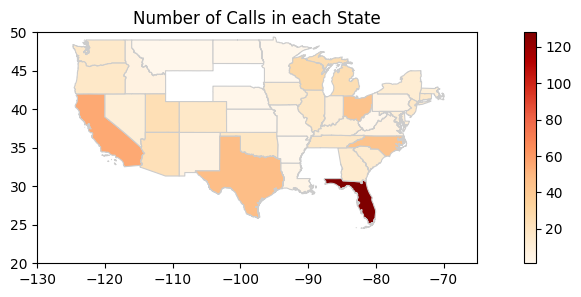

In [19]:
# Let's break it down by state
state_counts = df['state'].value_counts().reset_index()
state_counts.columns = ['state', 'count']
us_states = gpd.read_file('cb_2018_us_state_500k.shp')
us_states = us_states.merge(
    state_counts, left_on='NAME', right_on='state', how='left')
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
us_states.plot(
    column='count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8',
    legend=True)
ax.set_title(f"Number of Calls in each State")
ax.set_xlim(-130,-65)
ax.set_ylim(20,50)
plt.show()


Florida, California, and Texas seem to lead, though it's no wonder considering the amount of people within these states, though in general the data seems pretty well distributes. Let's try to find out the state with the most calls per 1M people:

(20.0, 50.0)

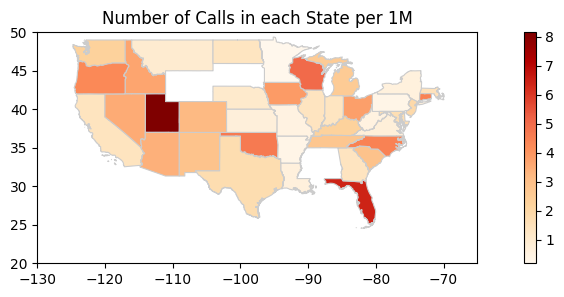

In [20]:
# load a dataset with the population of each state
csv_link = 'https://gist.githubusercontent.com/bradoyler/0fd473541083cfa9ea6b5da57b08461c/raw/fa5f59ff1ce7ad9ff792e223b9ac05c564b7c0fe/us-state-populations.csv'
state_csv = pd.read_csv(csv_link)
us_states_with_pop = us_states.merge(
    state_csv, left_on='STUSPS', right_on='code', how='left')
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
us_states_with_pop['calls_per_1M'] = (us_states_with_pop['count'] / us_states_with_pop['pop_2014']) * 1000000
us_states_with_pop.plot(
    column='calls_per_1M', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8',
    legend=True)
ax.set_title(f"Number of Calls in each State per 1M")
ax.set_xlim(-130,-65)
ax.set_ylim(20,50)

The above map gives us a more accurate map of where there are more "dangerous" calls.
Although 600 calls is a low number to have clear-cut conclusions from, seems like Utah and Florida have the most cases.
Of course, we shouldn't forget about Canada and Alaska:


In [21]:
print(f"{len(df_clean[df_clean['state'] == 'Canada'])} calls from Canada")

canada_population_millions = 37.59
print(f"{len(df_clean[df_clean['state'] == 'Canada']) / canada_population_millions} calls per 1M people in Canada")

print(f"{state_counts[state_counts['state'] == 'Alaska']['count'].values[0]} calls from Alaska")
print(f"{us_states_with_pop[us_states_with_pop['NAME'] == 'Alaska']['calls_per_1M'].values[0]} calls per 1M people in Alaska")

4 calls from Canada
0.10641127959563713 calls per 1M people in Canada
1 calls from Alaska
1.3573456833692579 calls per 1M people in Alaska


All in all, a pretty insignificant number of calls for Canada and Alaska.

### False Alarm
Next, let's take a look at the false alarm column, to figure out how much data tagged as false alarm do we have:

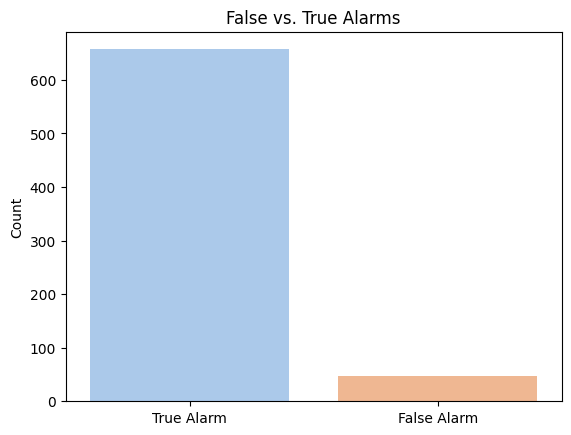

In [22]:
g = sns.countplot(x='false_alarm', data=df_clean)
g.set_xticklabels(['True Alarm', 'False Alarm'])
g.set_xlabel('')
g.set_ylabel('Count')
g.set_title('False vs. True Alarms')
plt.show()

Seems like the vast majority of the calls were not, in fact, false alarms. Which could pose a problem if we were to try and detect whether or not a call was a false alarm with our model.

### Deaths
Let's also look at how many calls resulted in deaths:

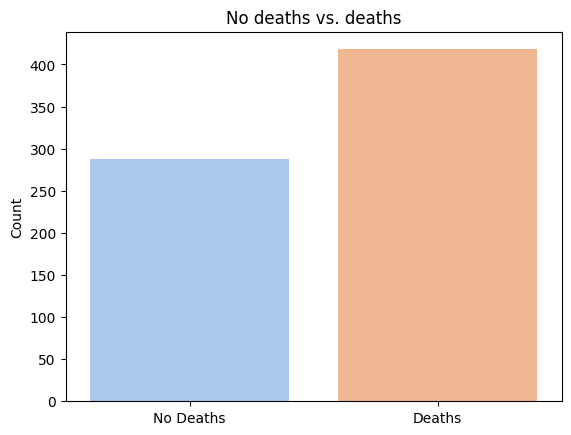

In [23]:
g = sns.countplot(x='deaths_binary', data=df_clean)
g.set_xticklabels(['No Deaths', 'Deaths'])
g.set_xlabel('')
g.set_ylabel('Count')
g.set_title('No deaths vs. deaths')

plt.show()

Seems like in general, the feature is not too skewed, though there are a more calls that resulted in one or more deaths.

Let's combine the "deaths_binary" and "false alarm" features to split the data into 4 categories:
1. true_alarm_death - deadly cases, which can indicate a failure of the opeartor, or a hopeless case.
2. false_alarm_death - If cases like these exist, they can indicate a corruption of data of one of the columns - either there was no death, or it was a true alarm.
3. true_alarm_no_death - Cases that were potentially stopped by the operator
4. false_alarm_no_death - Cases where it was truly a false alarm.


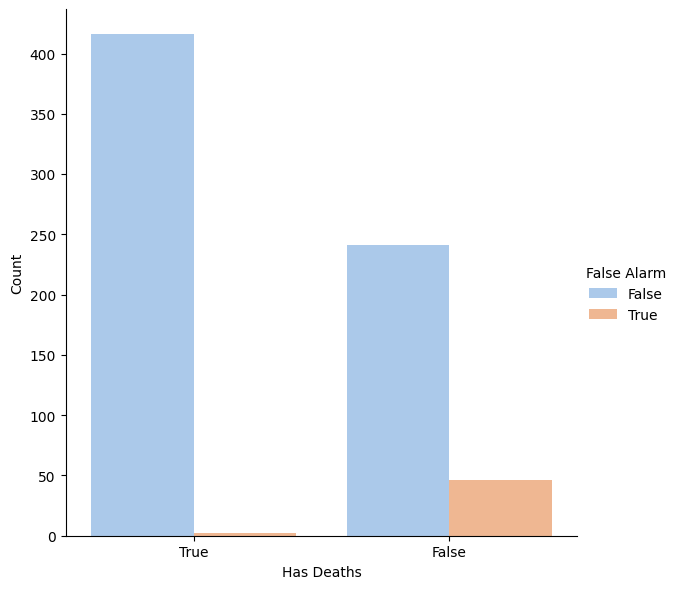

In [24]:
df_clean_str = df_clean.copy()
df_clean_str['false_alarm'] = df_clean['false_alarm'].replace({True: 'True', False: 'False'})
df_clean_str['deaths_binary'] = df_clean['deaths_binary'].replace({True: 'True', False: 'False'})
df_clean_str['potential_death'] = df_clean['potential_death'].replace({True: 'True', False: 'False'})

g = sns.catplot(
    data=df_clean_str, kind="count",
    x="deaths_binary",
    hue="false_alarm",
    height=6
)
g.set_axis_labels("Has Deaths", "Count")

g.legend.set_title("False Alarm")
# plt.tight_layout()
plt.show()


Hmm. seems like a small amount of the results have deaths while also being tagged as a false alarm. From the datasets description about "false_alarm" feature: "Additional metadata (date, state, citizen initiated, deaths, potential death, and false alarm) were manually coded based on the descriptions, recordings, and additional news sources". So, seems like it isn't entirly trustworthy right? let's see the datapoints themselves:

In [25]:
# Get data points with deaths_binary = True and false_alarm = True
df_deaths_false_alarm = df_clean[(df_clean['deaths_binary'] == True) & (df_clean['false_alarm'] == True)]
# Only two data points
print(df_deaths_false_alarm['description'].values[0])
print(df_deaths_false_alarm['description'].values[1])

– In Jan. 2011 a man walked into the Monroe Falls (Ohio) police department lobby, dialed 911 from a cellular and confessed to strangling his sister. Lawrence Hanly was arrested by officers without incident.
– Olidia Day fled in her car from her ex-boyfriend when he arrived at her home. She dialed 911 for help and reached a Sunrise (Fla.) dispatcher, and then drove to the Plantation police station, where she was shot and killed by the man, who then killed himself. A controversy followed about the calltaker’s performance, and the incident was highlighted on a “Dr. Phil” episode.


The incidents appear very much real, and look like it was a True alarm indeed.

### Potential deaths
Let's have a look at the distribution:

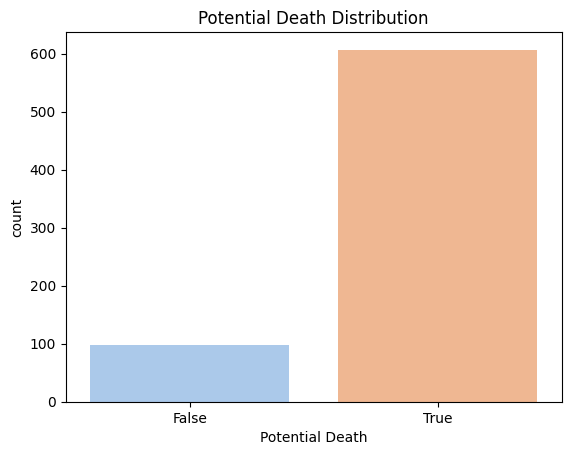

In [26]:
# show distribution of column potential_death
g = sns.countplot(x='potential_death', data=df_clean)
g.set_title("Potential Death Distribution")
g.set_xlabel("Potential Death")

plt.show()

Let's also break it down by potential death and deaths_bool, to try and find discrepencies in the data:

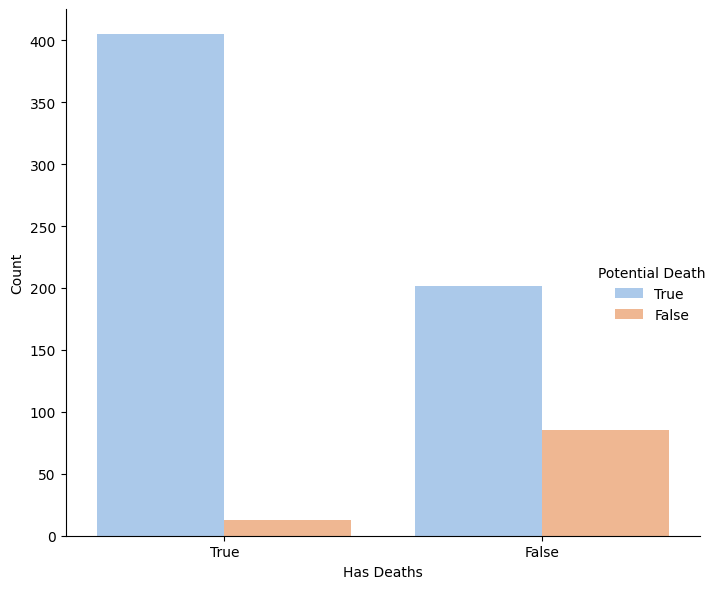

In [27]:
g = sns.catplot(
    data=df_clean_str, kind="count",
    x="deaths_binary",
    hue="potential_death",
    height=6)
g.set_axis_labels("Has Deaths", "Count")
g.legend.set_title("Potential Death")
plt.tight_layout()
plt.show()

So, there are several cases where there are deaths in spite of no death potential. Let's have a look at the data to determine the cause:

Next, let's see the spread death count in the dataset:

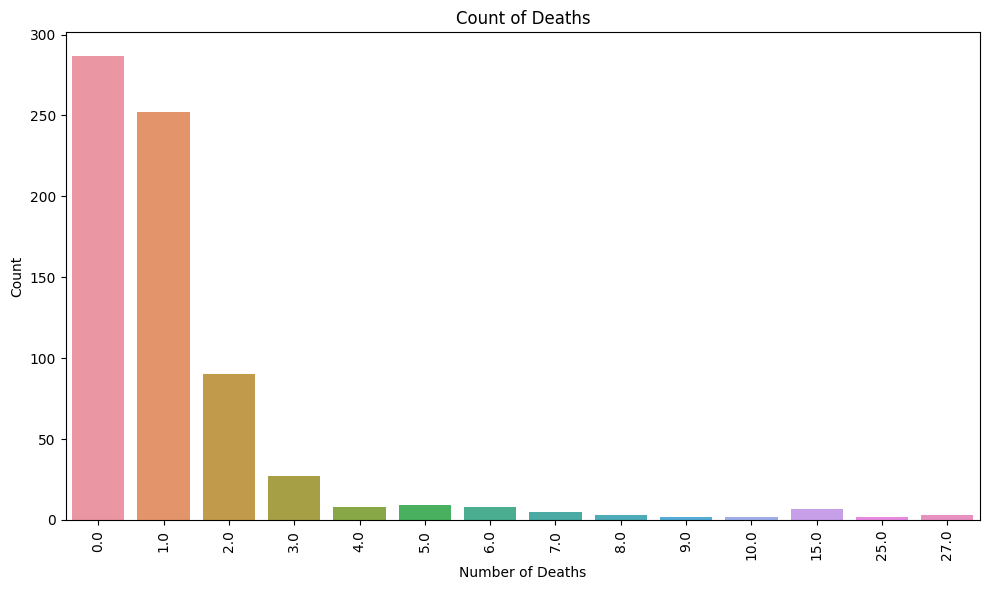

In [28]:
# Create a count plot of the 'deaths' column
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='deaths')
plt.xlabel('Number of Deaths')
plt.ylabel('Count')
plt.title('Count of Deaths')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

As we can see, most of the calls have 0-1 deaths, and a minority have more than 2.

### Other

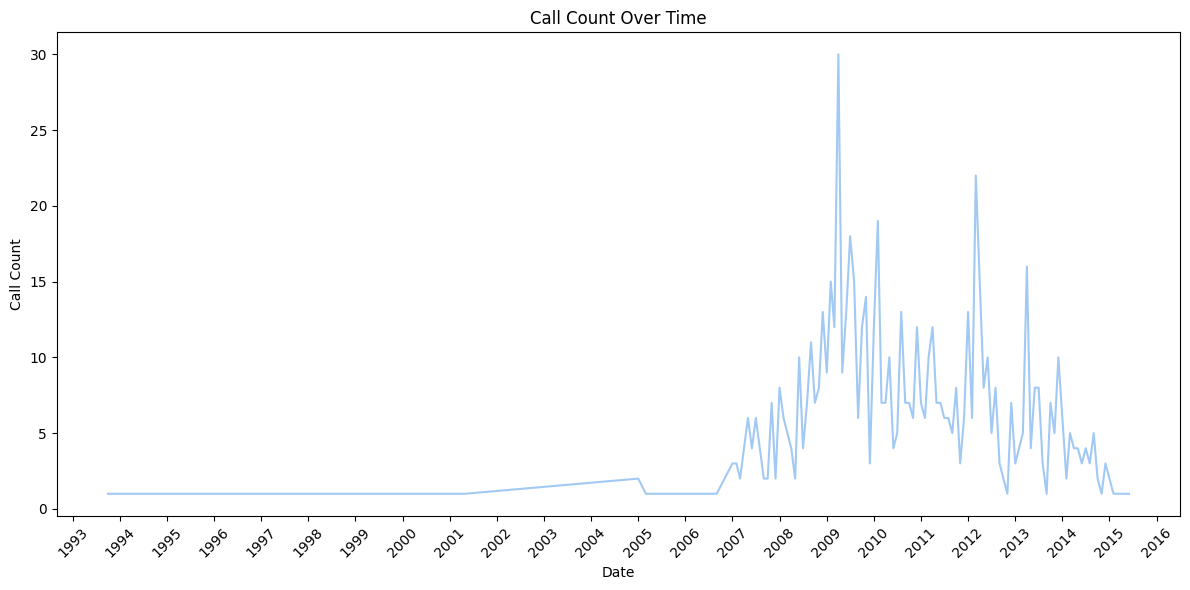

In [29]:
# Group the data by date and count the calls for each date
calls_by_date = df_clean['date_dt'].value_counts().reset_index()
years_locator = YearLocator(base=1)
years_format = DateFormatter('%Y')


# Create a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=calls_by_date, x='date_dt', y='count')

plt.gca().xaxis.set_major_locator(years_locator)
plt.gca().xaxis.set_major_formatter(years_format)

plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Call Count')
plt.title('Call Count Over Time')
plt.tight_layout()
plt.show()


Another attribute we have is the "break" column, which tells us how long into the call the audio snippet begins. Let's see it plotted:

In [30]:
calls_by_break = df_clean['break'].value_counts().reset_index()
calls_by_break

,break,count
0,3.0,56
1,2.0,56
2,5.0,46
3,6.0,43
4,4.0,38
...,...,...
107,63.0,1
108,695.0,1
109,603.0,1
110,519.0,1


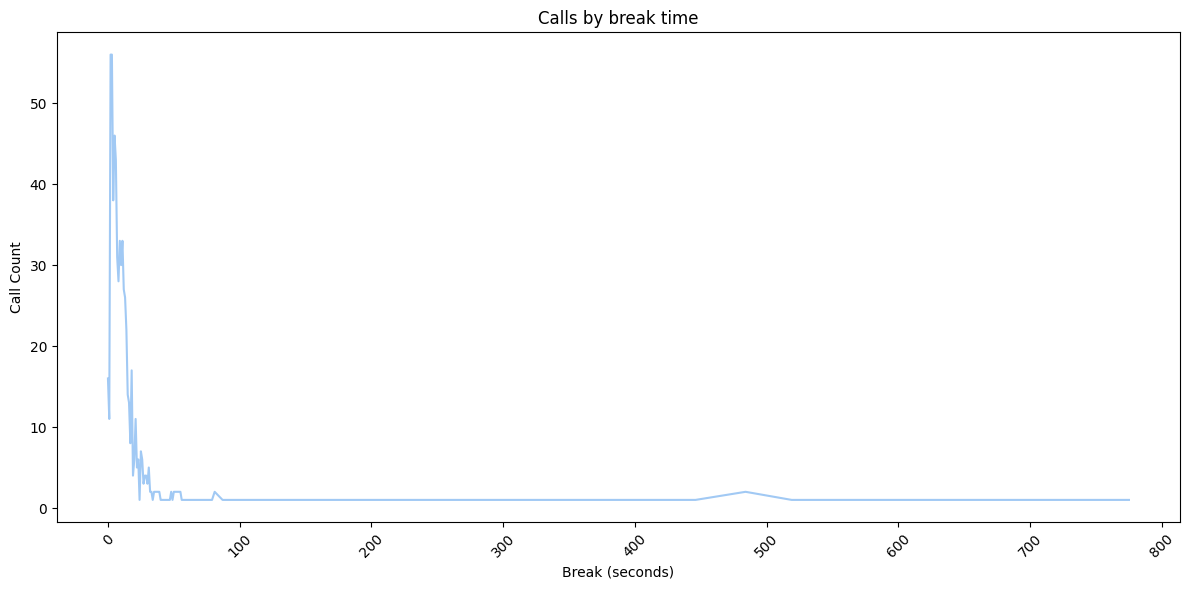

In [31]:
# Group the data by break and count the calls for each date
calls_by_break = df_clean['break'].value_counts().reset_index()

# Create a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=calls_by_break, x='break', y='count')

plt.xticks(rotation=45)

plt.xlabel('Break (seconds)')
plt.ylabel('Call Count')
plt.title('Calls by break time')
plt.tight_layout()
plt.show()

So while the vast majority of calls are from the very beginning of the call, some aren't. We should keep this in mind in case our model will assume the calls are actually the first 6 seconds, as the name of the dataset suggests.

### PCA
Let's perform PCA on the data. We are going to one-hot encode the State data, and add to that 4 numeric columns we have. 2 of them are binary. deaths_binary is derived from deaths, so that can be dropped. We also use a scaler for the data, since numbers of different scales can skew the data

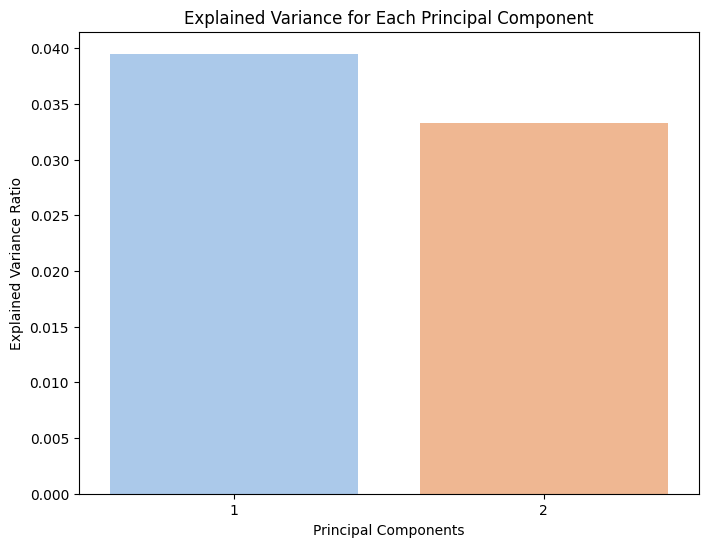

In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_pca = df[['false_alarm', 'potential_death', 'deaths', 'break']].dropna()

# one hot encode the state column
one_hot_state = pd.get_dummies(df[['state']], columns=['state'])
# join the one hot encoded columns to the main dataframe
df_pca = pd.merge(df_pca, one_hot_state, left_index=True, right_index=True)
scaler = StandardScaler()
df_pca = scaler.fit_transform(df_pca)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_pca)

pc_df = pd.DataFrame(data = principal_components, columns = ['pc1', 'pc2'])

plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(1, 3), y=pca.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance for Each Principal Component')

plt.show()


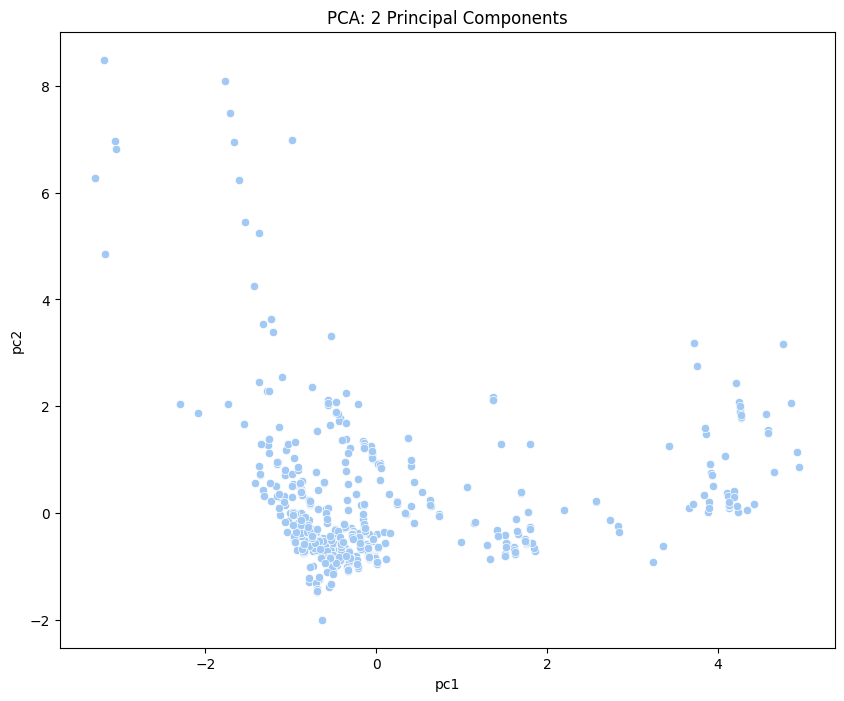

In [60]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pc_df, x='pc1', y='pc2')
plt.title('PCA: 2 Principal Components')
plt.show()


Now, let's apply k-means to group these points and see if we can learn anything about them:

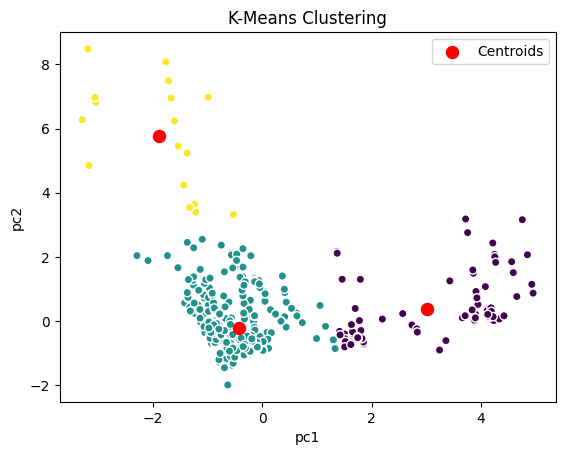

In [80]:
from sklearn.cluster import KMeans

# Selecting the features for clustering
X = pc_df[['pc1', 'pc2']]

# We can see roughly 4 clusters
num_clusters = 3

# Create k-means model
kmeans = KMeans(n_clusters=num_clusters, random_state=3)

# Fit the model to the data
kmeans.fit(X)

# Add the cluster labels to the DataFrame
pc_df['cluster'] = kmeans.labels_

# Visualize the clusters
plt.scatter(pc_df['pc1'], pc_df['pc2'], c=pc_df['cluster'], marker='o', edgecolors='w')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='.', label='Centroids')
plt.title('K-Means Clustering')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend()
plt.show()


From this scatter plot we can identify largly 3 groups - yellow, green and purple. Let's see if we can identify any trend in these groups in number of deaths and break:

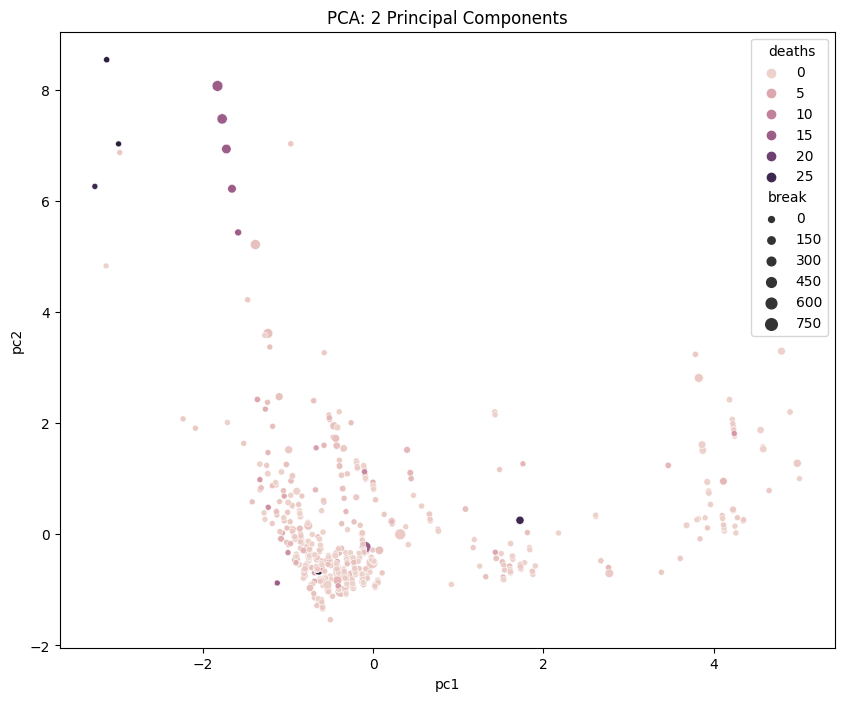

In [35]:
pc_df_full = pd.merge(pc_df, df, left_index=True, right_index=True)
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pc_df_full, x='pc1', y='pc2', hue='deaths', size='break')
plt.title('PCA: 2 Principal Components')
plt.show()


Seem like the outliers in the top left are made of long breaks and high deaths. We can see in the lower left and lower right, the "green" and "purple" groups, have a low number of deaths and short breaks, generally. Let's try to take a look at "potential_death" and "false_alarm" features to get a better look at these groups:

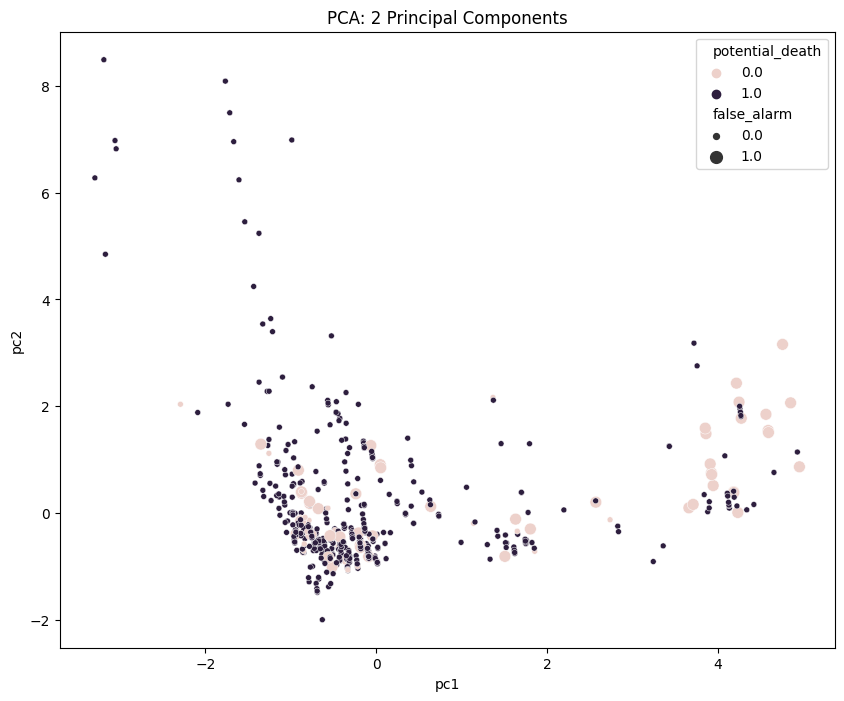

In [83]:
pc_df_full = pd.merge(pc_df, df, left_index=True, right_index=True)
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pc_df_full, x='pc1', y='pc2', hue='potential_death', size='false_alarm')
plt.title('PCA: 2 Principal Components')
plt.show()

Seems like the difference between them is with the rightmost group having more false alarms, without potenital deaths, and the left most have potential deaths, without the false alarm. We can also see there are almost no cases of both of these features happening in the same time, which makes sense - if it has potential deaths, it isn't a false alarm. However if it isn't a false alarm it's possible to not have potential deaths - but we don't see many such cases here 

# EDA - Audio

First off, let's have a preface about audio data and how we can analyze it.
### 1. Frequency:
  - Describes the rate of oscillation (vibration).
  - Denoted in Hz (1/sec).
  - Is understood by the human ear as 'pitch'.
  - The human ear is considered to be able to hear within the range of 20 Hz to 20,000 Hz.
  
  <img src="https://uploads-cdn.omnicalculator.com/images/britannica-wave-frequency.jpg" width="500"/>


### 2. Intensity (Power):
  - Proportional to the **amplitude** of the audio wave [[source]](http://theory.physics.ubc.ca/341-current/dB.pdf).
  - Denoted in dB, with a pre-defined base 0dB, as it is a comapritive logarithmic scale.
  - Is understood by the human ear as 'loudness'
  - dB = 20 * log10(amplitude) [[source]](https://blog.demofox.org/2015/04/14/decibels-db-and-amplitude/).
  
  <img src="https://theproaudiofiles.com/wp-content/uploads/2018/06/decibel-chart.png" width="500"/>

### 3. The relationship between Frequency and Intensity:
  
  <img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780124722804500162-f13-15-9780124722804.gif" width="500"/>

### 4. Sample Rate:
  - The rate at which we sample discrete audio signals, the standard of audio sampling is 44.1 kHz ([for historic reasons](https://www.cardinalpeak.com/blog/why-do-cds-use-a-sampling-rate-of-44-1-khz)), that is 44,100 samples per second.

  <img src="https://cdn.shopify.com/s/files/1/0970/0050/files/Sample_Rate.png?1870870584085320152" width="600"/>

### 5. Time Domain vs Frequency Domain:
  - In the Time Domain we observe the audio signal as a function of time, see example image in (3).
  - In the Frequency Domain we observe the audio signal as a function of frequency, with each frequency's contribution to the signal being measured.

Now, let's see how we can utilize this information to plot audio data:

## Audio Bring-up

In [36]:
# Imports
from scipy import fft
import matplotlib.patches as mpatches
import librosa as lbrs
import IPython
import IPython.display as ipd

## Analysis in The Time Domain

First we can sample an audio file to listen too, so we can compare the data to actual human comprehendible sound:

In [37]:
# load metadata from csv to a pandas dataframe
metadata_df = pd.read_csv(metadata_path)

# TODO (ram): need to find the duplicates
metadata_df.drop_duplicates(subset=['filename'], inplace=True)
metadata_df.reset_index(drop=True, inplace=True)

# sample a single audio file
sample = metadata_df.sample(1)
sample_filename = sample['filename'].iat[0]
sample_path = get_path_from_filename(sample_filename)

# Create playable audio
IPython.display.display(ipd.Audio(sample_path))

We can use several graphs to analyze audio data:
### Waveform
The first graph is waveform - it shows the amplitude of the recording over time
Let's see how it looks:

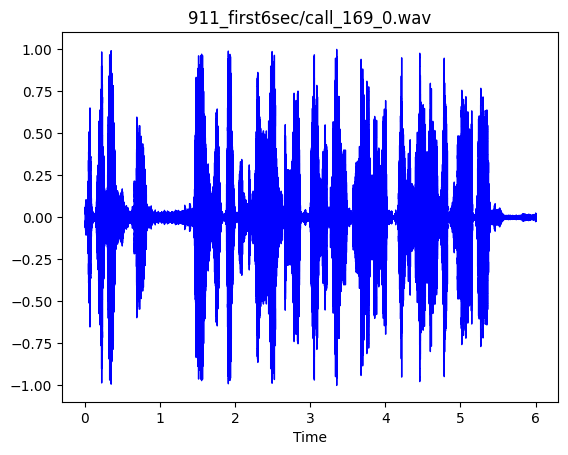

In [38]:
# Get digital signal data
sample_data, sample_rate = lbrs.load(sample_path)

# Plot waveform
lbrs.display.waveshow(sample_data, sr=sample_rate, color='b')
plt.title(sample_filename)
plt.show()

Let's zoom in a bit:

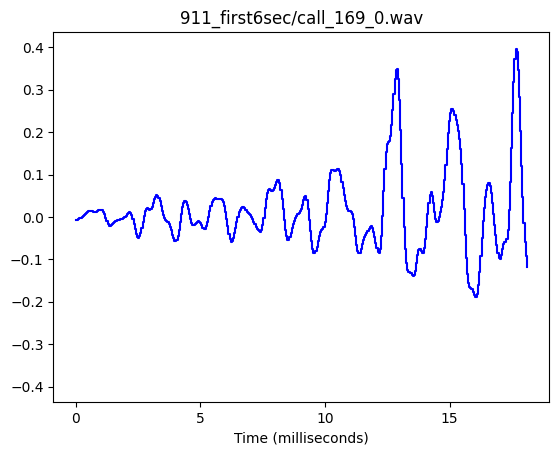

In [39]:
# fetch a smaller segment in the middle of the signal
mid_point = len(sample_data) // 2
zoom_in_data = sample_data[mid_point - 200 : mid_point + 200]

lbrs.display.waveshow(
    zoom_in_data, sr=sample_rate, axis='ms', label=sample_filename, color='b')
plt.title(sample_filename)
plt.show()

If we can see a differnce in the amplitude of conversations between dangerous and not-dangerous calls, we could use this data in a model. for example, if we see "louder" conversations tend to be more dangerous.

##Analysis in the Frequency Domain - Magnitude spectrum

The Magnitude Spectrum of a signal describes a signal using frequency and amplitude. That is frequency components of a periodic signal are plotted using Frequency Domain - frequencies plotted in X-axis and amplitude plotted in Y-axis

To understand the following method, we need to go over a few things:
#### 1. Applying FFT
  Applying FFT to the audio data will return an array of complex number, which can also be interpreted as vectors, with the norm of each vector (absolute value of a complex number) being the *power* of the frequency, and the direction of the vector (angle) repesnting the *phase* of the frequency.

  For example:

  <img src="https://robocrop.realpython.net/?url=https%3A//files.realpython.com/media/pianofreqblue.ff266a14503f.png&w=875&sig=15d13cbf8bbfce339bedb40297c8ac161db867bc" width="500"/>

  Here we can see that the **highest** note was played the **weakest**.

#### 2. Frequency Bins:
  When Applying an FFT on a continuous wave,because between any two discrete points are infinite points in the continuous field, we essnently check the "average" power of some small sub segment of the wave, which we call a frequency bin, in most cases our bins will be very small.

  The most intuitive way to think of this is as if we're creating a Histogram

Now let us use this information to create a magnitude spectrum:

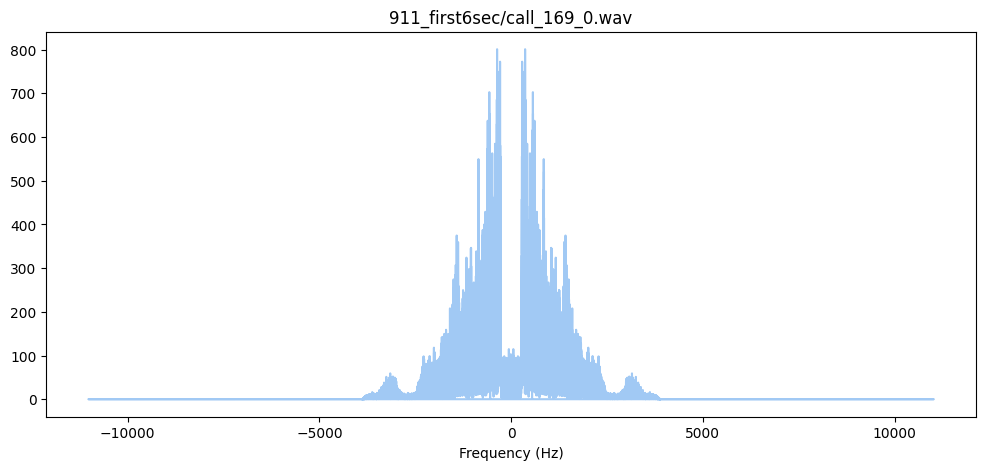

In [40]:
# get frequency bins and magnitude
ft = fft.fft(sample_data)
mag_spec = np.abs(ft)
frequency_bins = fft.fftfreq(sample_rate*6, 1/sample_rate)

# plot
plt.figure(figsize=(12,5))
plt.plot(frequency_bins, mag_spec)
plt.xlabel('Frequency (Hz)')
plt.title(sample_filename)
plt.show()

Because we've used real numbers as the input for the FFT we've received this symmetry,
we want to remove this as the left half is superfluous, we will use scipy's rfft (real fft) for this:

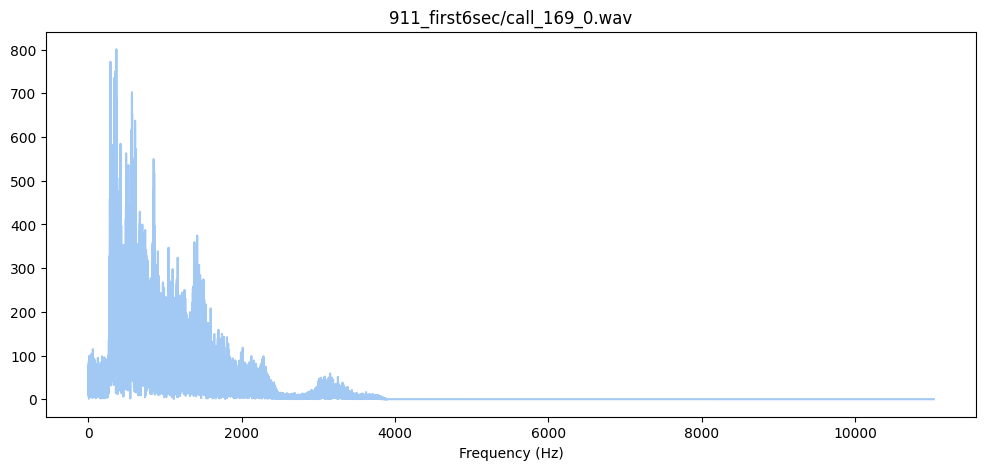

In [41]:
# switch to real fft
ft = fft.rfft(sample_data)
mag_spec = np.abs(ft)
frequency_bins = fft.rfftfreq(sample_rate*6, 1/sample_rate)

# stays the same
plt.figure(figsize=(12,5))
plt.plot(frequency_bins, mag_spec)
plt.xlabel('Frequency (Hz)')
plt.title(sample_filename)
plt.show()

Here we can see the frequency is plotted on the X-axis, while the amplitude is plotted on the y-axis

## Analysis in the Frequency Domain and Time Domain - Spectrogram
We can analyze in both the frequency and time domains using a "Spectrogram", which we will cover in this section.

#### Short-time Fourier Transform:
before we plot the spectrogram we need to familiarize ourselves with a short-term fourier transform, in this transformation we separate the signal into 'chunks' of equal lengths, and calculate the DFT for each segment, we then get a 2-dimensional array we can plot 'over-time' in the spectrogram.

The windows are overlapping.

There are 2 important terms we need to know:
1. Frame Size (Number of FFTs):
The length of each chunk window (including zero padding)
2. Hop Length:
The number of audio samples per STFT column


### Reading the Spectrogram
The graph is read in the following way:
- The x-axis represents the passage of time, similarly to a wave plot.
- The y-axis represents the frequencies, like the x-axis of the magnitude spectrum
- The hue of the graph represents the intensity (power) of the frequency, with colder/lighter hues representing lower values, and darker/hotter hues representing higher values.

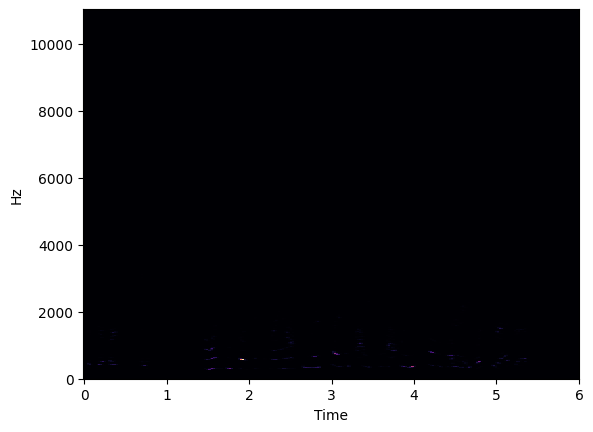

In [42]:
# standard sizes
frame_size = 2048
hop_size = 512

# Calculate the power of each chunk
stft_data = lbrs.stft(sample_data, n_fft=frame_size, hop_length=hop_size)
stft_data = np.abs(stft_data) ** 2

# display over linear graph
lbrs.display.specshow(
    stft_data, hop_length=hop_size, sr=sample_rate, x_axis='time', y_axis='linear')
plt.show()

Hmmm. We can barely see anything, except minor heat maps in the lower part.
This is because the plotting is linear, and most (higher) sounds are not as interesting or audible by humans,
so we can move to a lograithmic plot to improve the readability of the spectogram:

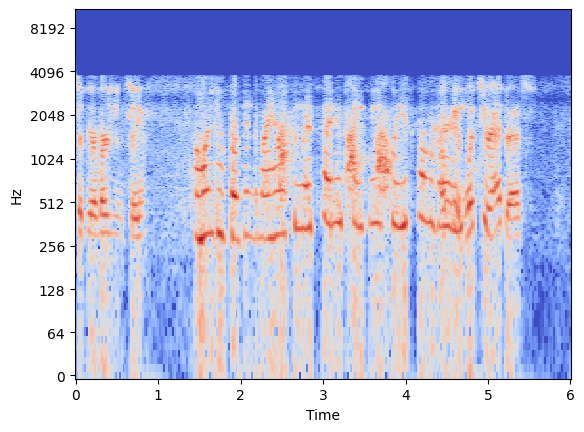

In [43]:
# standard sizes
frame_size = 2048
hop_size = 512

# use dB which as stated above are log-scaled
stft_data = lbrs.stft(sample_data, n_fft=frame_size, hop_length=hop_size)
stft_data = np.abs(stft_data)
stft_data_log = lbrs.amplitude_to_db(stft_data)


# switch y-axis to log
lbrs.display.specshow(
    stft_data_log, hop_length=hop_size, sr=sample_rate,
    x_axis='time', y_axis='log')
plt.show()

This graph is more human-readable.
As we can see, above ~4096Hz we don't have any data. That is because these are telephone calls - telephone calls frequency range is limited at around 3400 Hz, even though human hearing is up to 20KHz. That way telephone calls use less data.

### Analyzing the data

Now that we have seen different ways of representing the data, let's plot some examples from our dataset and see if we can spot any visible trends that differentiate between dangerous and not dangerous calls:

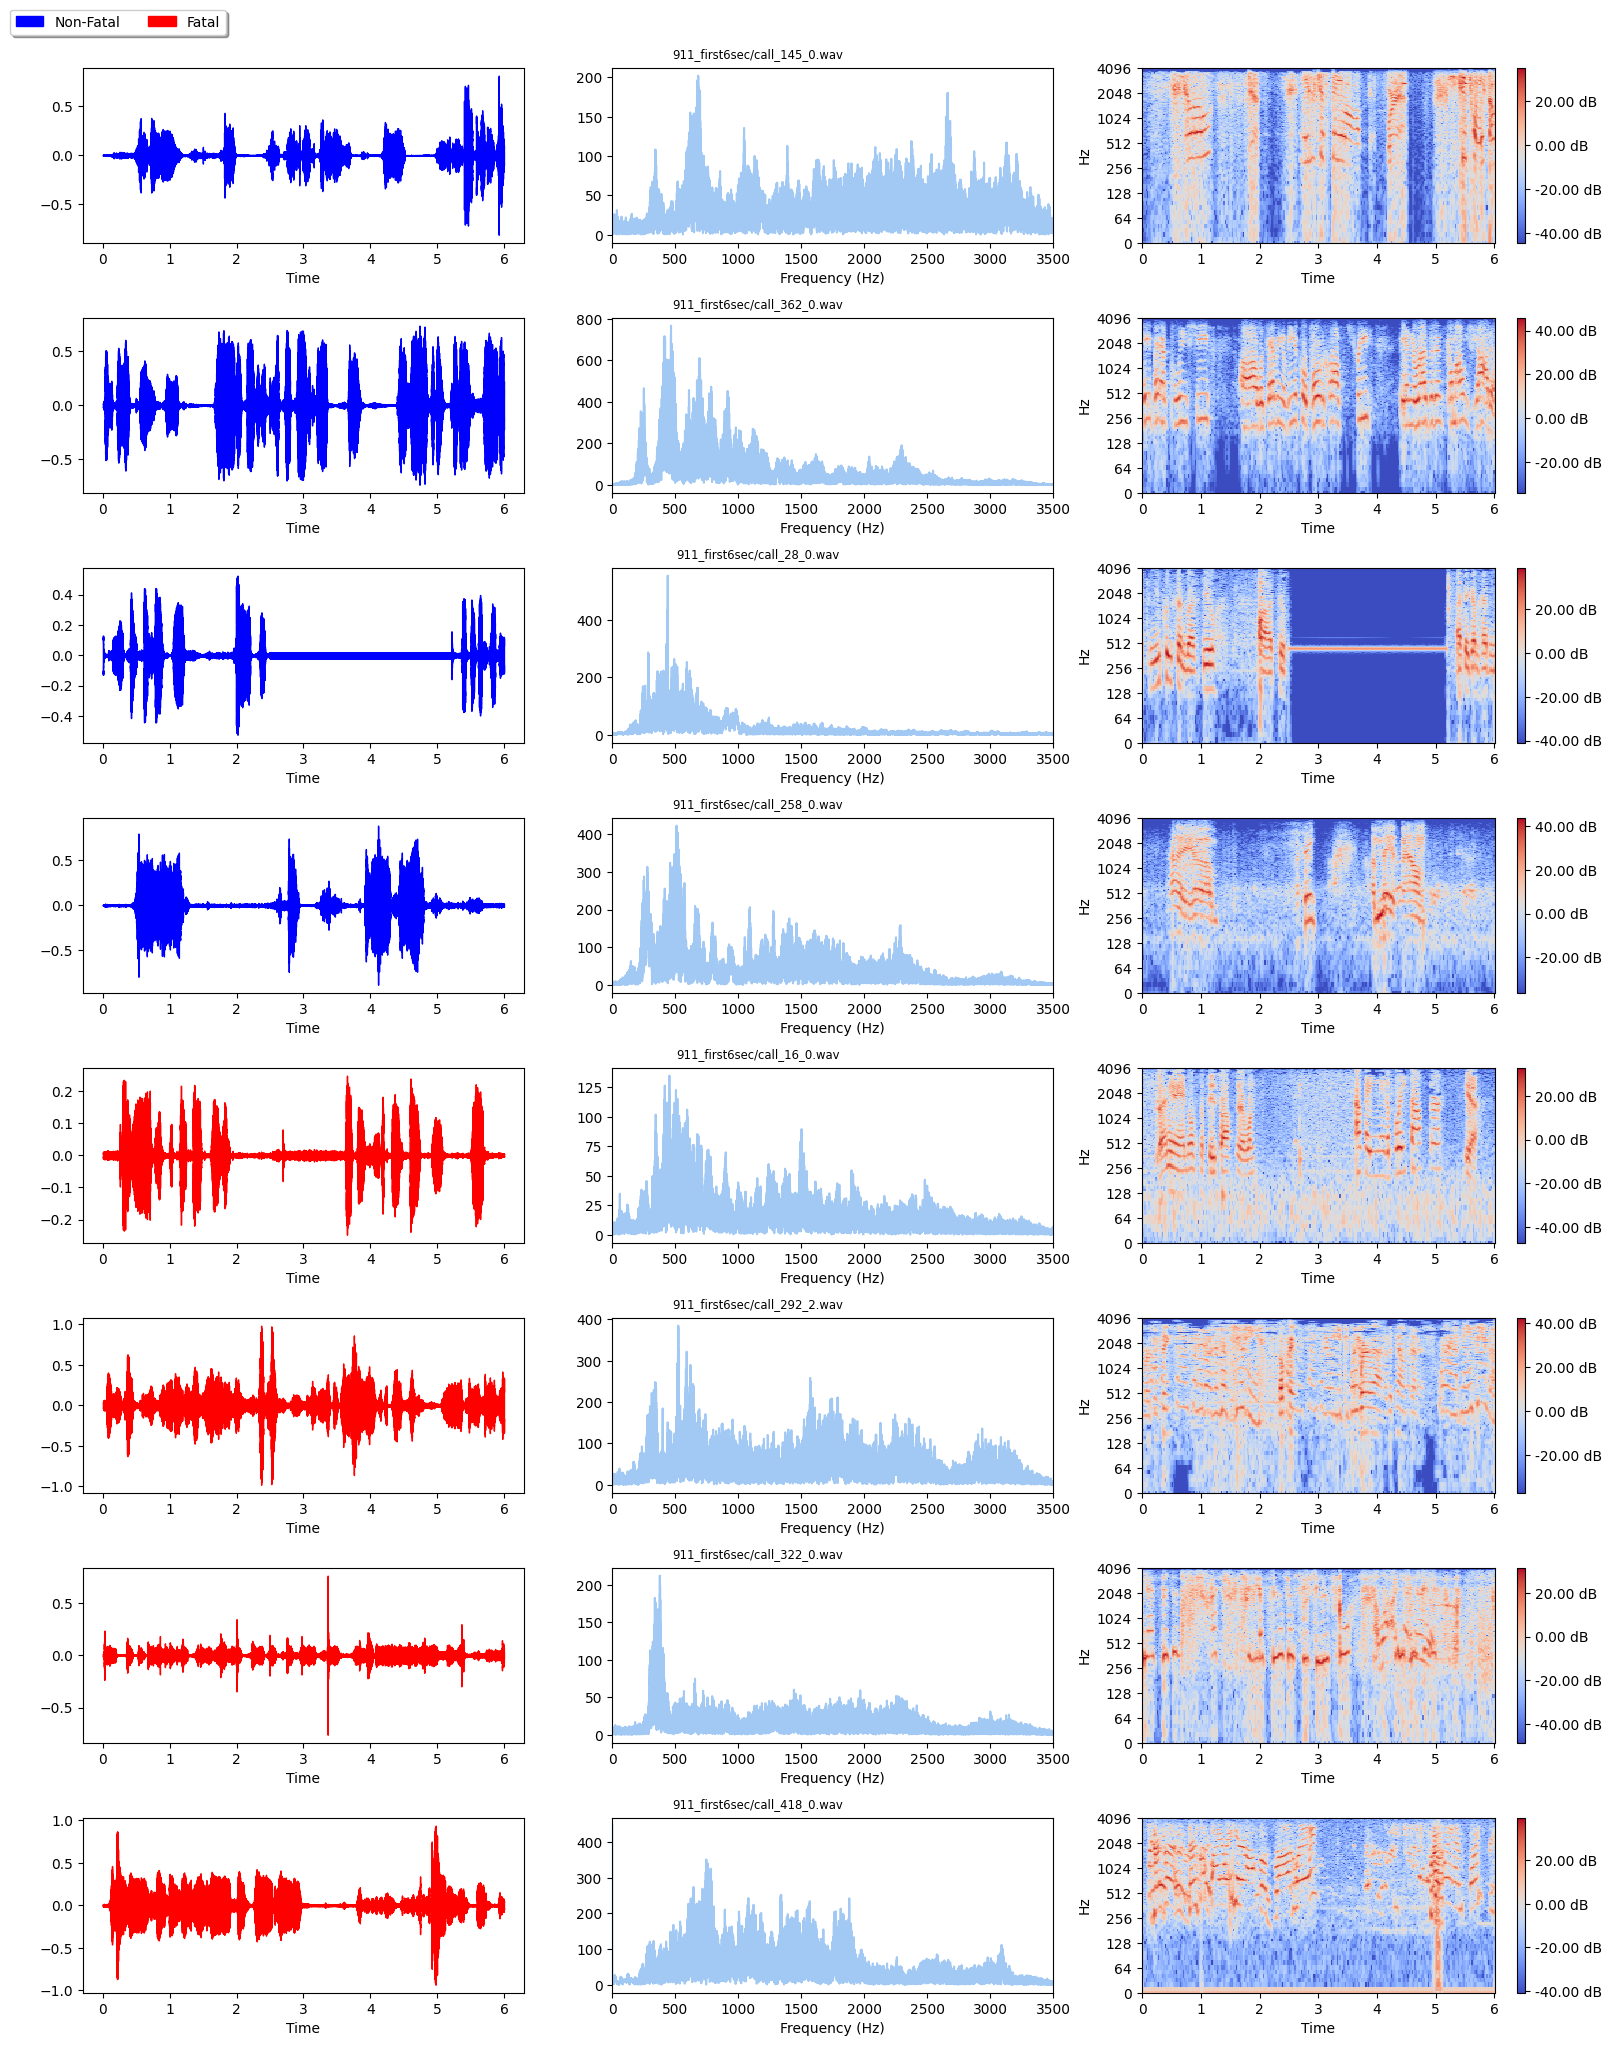

In [44]:
def get_audio_data(audio_file_name):
    audio_file_path = get_path_from_filename(audio_file_name)
    data, sample_rate = lbrs.load(audio_file_path)
    return data, sample_rate

def magnitude_spectrum_plot(data, sample_rate, ax):
  ft = np.fft.rfft(data)
  mag_spec = np.abs(ft)
  frequency_bins = fft.rfftfreq(sample_rate*6, 1/sample_rate)

  ax.plot(frequency_bins, mag_spec)
  ax.set_xlabel('Frequency (Hz)')
  ticks = ax.get_xticks()
  ticks = ticks.astype(np.int32)
  ax.set_xticks(ticks)

def spectrogram_plot(data, sample_rate, ax):
  stft_data = lbrs.stft(data)

  # use dB which as stated above are log-scaled
  stft_data = np.abs(stft_data)
  stft_data_log = lbrs.amplitude_to_db(stft_data)

  # switch y-axis to log
  return lbrs.display.specshow(
      stft_data_log, sr=sample_rate,
      x_axis='time', y_axis='log', ax=ax)

# create base figure
fig = plt.figure(figsize=(15, 20))
subfigs = fig.subfigures(nrows=8, ncols=1)

# add legend
red_patch = mpatches.Patch(color='red', label='Fatal')
blue_patch = mpatches.Patch(color='blue', label='Non-Fatal')
fig.legend(
    handles=[blue_patch, red_patch], bbox_to_anchor=(0.1, 1.02),
    ncol=2, fancybox=True, shadow=True)

# populate subfigures
for i, subfig in enumerate(subfigs):

  # create subplots in subfigure
  sub_axs = subfig.subplots(nrows=1, ncols=3, squeeze=True)
  subfig.subplots_adjust(left=0, top=0.9, right=1, bottom=0.2)

  # choose between fatal and non-fatal
  cls = 0
  if i >= 4:
    cls = 1
  color = 'r' if cls else 'b'

  # get audio data
  sample = metadata_df[metadata_df['deaths_binary'] == cls].sample(1, random_state=i)
  sample_filename = sample['filename'].iat[0]
  y, sr = get_audio_data(sample_filename)

  # add title to subfigure
  subfig.suptitle(sample_filename, x=0.45, fontsize='small')

  # add wave plot
  lbrs.display.waveshow(y=y, sr=sr, ax=sub_axs[0], color=color)

  # add magnitude spectrum
  sub_axs[1].axes.set_xlim(0, 3500)
  magnitude_spectrum_plot(y, sr, ax=sub_axs[1])

  # add spectrogram
  sub_axs[2].axes.set_ylim(0, 4096)
  img = spectrogram_plot(y, sr, ax=sub_axs[2])
  subfig.colorbar(img, ax=sub_axs[2], format=f'%0.2f dB')

plt.show()

So let's take a look at our three graphs:
- Waveform: No visible pattern to the naked eye
- Magnitude Spectrum: While hard to say for sure, from the samples we gathered it's possible that deadly calls are more active at higher frequencies
- Spectogram: The deadly calls seem more active at a wider range of the spectogram.

How can we explain these findings?
Maybe, when the caller is danger, there is more tendency to use very high and very low frequencies.
The fundamental frequency of the human voice, that is, the frequency most often used in conversation, is between 85 to 255 Hz. This is the range most active when looking at the spectogram of the non-deadly calls. usage outside of that range could indicate screams, people talking in an emotional state, etc.

Based on these findings, we will try to create a model that will discern between deadly and non-deadly calls using the audio data.

# Model Training

## Audio-based models

### MFCC Model - Introduction
We will begin our attempts with models using Mel-frequency cepstral coefficients (MFCCs) as features, using as a reference [[Hasan, Hasan & Hossain, 2021]](https://ietresearch.onlinelibrary.wiley.com/doi/full/10.1049/tje2.12082), although speech recognition is not the intent, the model we are attempting to build is tangentialially related, and so this is a good reference point to start from.

In [45]:
# Imports
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers, callbacks, regularizers
from sklearn import metrics
from tqdm import tqdm

# Configs
tqdm.pandas()

Let's create a method that receives the number of mfcc features and additionally window size and hop length (if needed).

In [46]:
def create_audio_series(audio_file_name):
    audio_file_path = get_path_from_filename(audio_file_name)
    data, sample_rate = lbrs.load(audio_file_path)
    return data, sample_rate

def mfcc_feature_extractor(filename, n_mfcc=13, n_fft=512, hop_length=124):
  data, sr = create_audio_series(filename)
  mfcc = lbrs.feature.mfcc(
      y=data, sr=sr, n_mfcc=n_mfcc,
      n_fft=n_fft, hop_length=hop_length
      )

  return np.mean(mfcc.T, axis=0)

Let's add a funciton to create the model, this allows us to easily tweak it's hyper-parameters

In [47]:
def create_model(input_shape, hidden_layers, unit_scalar=3,
                 optimizer_name='Adam', learning_rate=0.0005,
                 activation='tanh'):
  if unit_scalar < 0:
    raise AttributeError("unit_scalar must be non-negative")

  # create model & input layer, with the number of input layers
  # equal to the number of features per sample
  model = models.Sequential()
  model._name = f'model_{hidden_layers}hl_{input_shape[0]}mfcc'
  model.add(layers.InputLayer(input_shape=input_shape))

  # add hidden layers dynamically
  for i in range(hidden_layers):
    units = 2 ** (hidden_layers + unit_scalar - i)
    lyr = layers.Dense(units=units, activation=activation)
    lyr._name = f'hidden_layer_{i+1}'
    model.add(lyr)

  # out put layer of size 2 as the number of classes
  out_lyr = layers.Dense(units=2, activation='softmax')
  out_lyr._name = 'output_layer'
  model.add(out_lyr)

  # TODO add optimizer scheduler?
  # https://keras.io/api/optimizers/

  # add optimizer and compile model
  opt = getattr(optimizers, optimizer_name)
  model.compile(
    loss='sparse_categorical_crossentropy',
    # TODO other metrics?
    metrics=['accuracy'],
    optimizer=opt(learning_rate))

  return model

### MFCC Model - Large Model
We will begin with what the aforementioned paper referenced as higher performing models, specifically a model using 25 MFCC features, and 4 hidden layers

##### Extracting Features and Classes
MFCCs are essentialy an extension of the STFT that we've seen in the previous section, in that the MFCCs are computed by breaking up the signal into windows and computing the DFT for each window, but expands upon this by mapping the signal to the mel-scale, taking the log of mapping and applying a discrete cosine transform, with the MFCC being the magnitude of the resulting spectrum.

In [48]:
metadata_df = df_clean
filenames = metadata_df['filename']
features = filenames.progress_apply(mfcc_feature_extractor, n_mfcc=25)
features.rename('features', inplace=True)

features_named = pd.concat([filenames, features], axis=1)
features_named.head(10)

  1%|          | 5/706 [00:00<00:16, 43.07it/s]

100%|██████████| 706/706 [00:11<00:00, 62.82it/s]


,filename,features
id,,
0,911_first6sec/call_2_0.wav,"[-496.0407, 136.32658, -38.824543, -2.9566538,..."
1,911_first6sec/call_8_0.wav,"[-542.26483, 113.492096, -54.898438, -16.93544..."
2,911_first6sec/call_9_0.wav,"[-469.10492, 144.50131, -53.16923, -35.661564,..."
3,911_first6sec/call_10_0.wav,"[-461.7921, 102.00011, 4.277876, -3.2980382, -..."
4,911_first6sec/call_11_0.wav,"[-388.4136, 191.76453, -68.483246, -28.393343,..."
5,911_first6sec/call_12_0.wav,"[-366.63202, 123.76255, -8.727579, -9.830455, ..."
6,911_first6sec/call_13_0.wav,"[-328.94275, 173.40771, -122.689316, -22.34019..."
7,911_first6sec/call_15_0.wav,"[-388.2811, 92.17107, 0.9139051, -14.596169, -..."
8,911_first6sec/call_16_0.wav,"[-500.0724, 121.41379, -37.13404, 13.093014, 2..."


In [49]:
print(f'Number of samples: {len(features)}')
print(f'Number of MFCCs per sample: {len(features[0])}')

Number of samples: 706
Number of MFCCs per sample: 25


Let's add labels to the calls, to see if they resulted in death:

In [50]:
# Create classification
classes_named = metadata_df[['filename', 'deaths_binary']]

classes_named = classes_named.rename(
  columns={'deaths_binary': 'resulted_in_deaths'})

# Create combied dataframe
features_classes = pd.merge(features_named, classes_named)
features_classes.head(10)

,filename,features,resulted_in_deaths
0,911_first6sec/call_2_0.wav,"[-496.0407, 136.32658, -38.824543, -2.9566538,...",True
1,911_first6sec/call_8_0.wav,"[-542.26483, 113.492096, -54.898438, -16.93544...",True
2,911_first6sec/call_9_0.wav,"[-469.10492, 144.50131, -53.16923, -35.661564,...",False
3,911_first6sec/call_10_0.wav,"[-461.7921, 102.00011, 4.277876, -3.2980382, -...",True
4,911_first6sec/call_11_0.wav,"[-388.4136, 191.76453, -68.483246, -28.393343,...",False
5,911_first6sec/call_12_0.wav,"[-366.63202, 123.76255, -8.727579, -9.830455, ...",True
6,911_first6sec/call_13_0.wav,"[-328.94275, 173.40771, -122.689316, -22.34019...",True
7,911_first6sec/call_15_0.wav,"[-388.2811, 92.17107, 0.9139051, -14.596169, -...",True
8,911_first6sec/call_16_0.wav,"[-500.0724, 121.41379, -37.13404, 13.093014, 2...",True
9,911_first6sec/call_17_0.wav,"[-335.36813, 180.51752, -75.116455, -6.7831364...",True


Now, to try and assess the potential of the model, we will run PCA on our data to see if, when reduced to 2 dimensions, there is a pattern of dangerous / not dangerous calls.

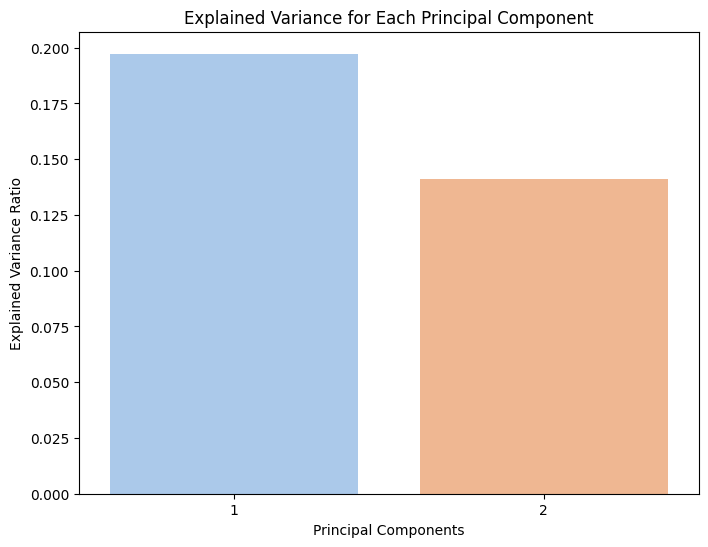

In [51]:
mfcc_features_list = features_classes['features'].tolist()
scaler = StandardScaler()
df_pca_audio = scaler.fit_transform(mfcc_features_list)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_pca_audio)

pc_df = pd.DataFrame(data = principal_components, columns = ['pc1', 'pc2'])

plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(1, 3), y=pca.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance for Each Principal Component')

plt.show()


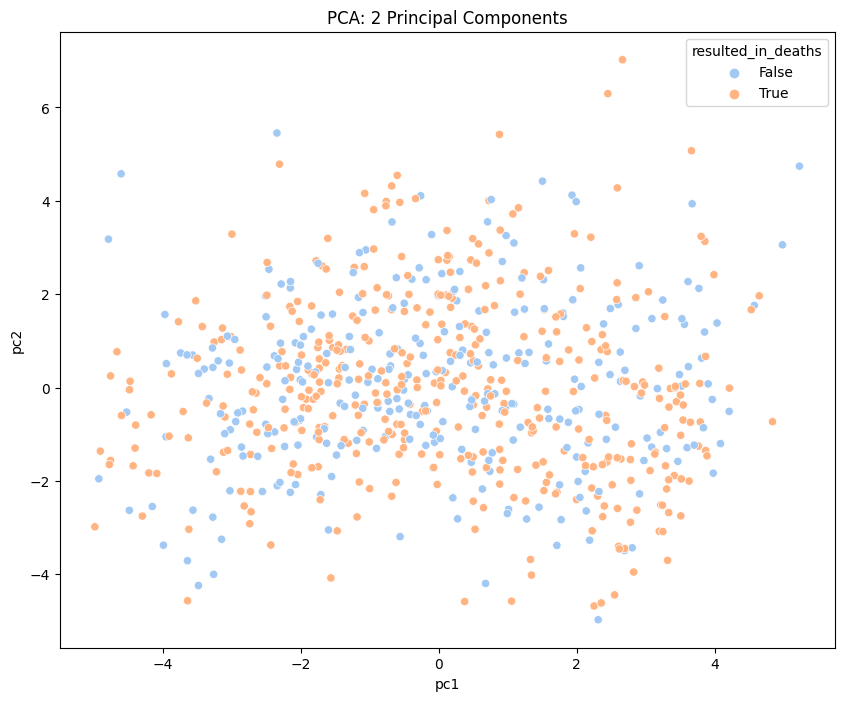

In [52]:
merged_df = pd.merge(pc_df, features_classes, left_index=True, right_index=True)
plt.figure(figsize=(10, 8))
sns.scatterplot(data=merged_df, x='pc1', y='pc2', hue='resulted_in_deaths')
plt.title('PCA: 2 Principal Components')
plt.show()


From the PCA we performed, there is no observable pattern of whether or not a call may result in death based on the PCA. Nevertheless, we are going to try and train a model based on that data and see the results, although we are not very optimistic.

In [53]:
# save to csv in new data directory
# TODO: Check if needed
new_data_dir = os.path.join(gen_data_dir, 'new')
features_classes_path = os.path.join(new_data_dir, 'features_classes.csv')
features_classes.to_csv(features_classes_path, encoding='utf-8', index=False)

Let's split the data to a test and train set:

In [54]:
features = np.array(features_classes['features'].tolist())
classes = np.array(features_classes['resulted_in_deaths'])

X_train_large_model, X_test_large_model, y_train_large_model, y_test_large_model = train_test_split(
    features, classes ,test_size=0.25, shuffle=True, stratify=classes, random_state=0)

Now, let's train the model on our data:

In [55]:
input_shape = (features.shape[1],)
hidden_layers = 4
unit_scalar = 3

large_model = create_model(
    input_shape=input_shape, hidden_layers=hidden_layers,
    unit_scalar=unit_scalar)

print(large_model.summary())

Model: "model_4hl_25mfcc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 128)               3328      
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                8256      
                                                                 
 hidden_layer_3 (Dense)      (None, 32)                2080      
                                                                 
 hidden_layer_4 (Dense)      (None, 16)                528       
                                                                 
 output_layer (Dense)        (None, 2)                 34        
                                                                 
Total params: 14226 (55.57 KB)
Trainable params: 14226 (55.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


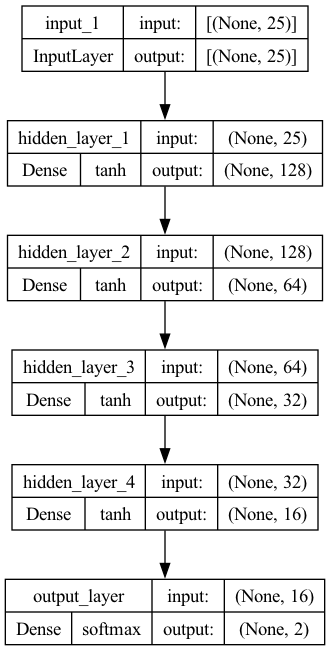

In [56]:
plot_model(large_model, show_shapes=True, show_layer_activations=True)

In [57]:
# define callbacks
reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=0.000005, verbose=1)
epochs = 500

large_fit  = large_model.fit(
    X_train_large_model,
    y_train_large_model,
    epochs=epochs,
    validation_data=(X_test_large_model, y_test_large_model),
    callbacks=[reduce_lr_callback],
    verbose=0)


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 31: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 41: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 51: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 61: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 71: ReduceLROnPlateau reducing learning rate to 5e-06.


KeyboardInterrupt: 

#### Assessing the Model

Let's see some info about our training:

In [ ]:
large_fit_history = pd.DataFrame(large_fit.history)
model_architecture = f'{features.shape[1]} MFCCs & {hidden_layers} Hidden Layers'
print(model_architecture)
print(f'Number of Actual Epochs: {large_fit_history.shape[0]}')

25 MFCCs & 4 Hidden Layers
Number of Actual Epochs: 500


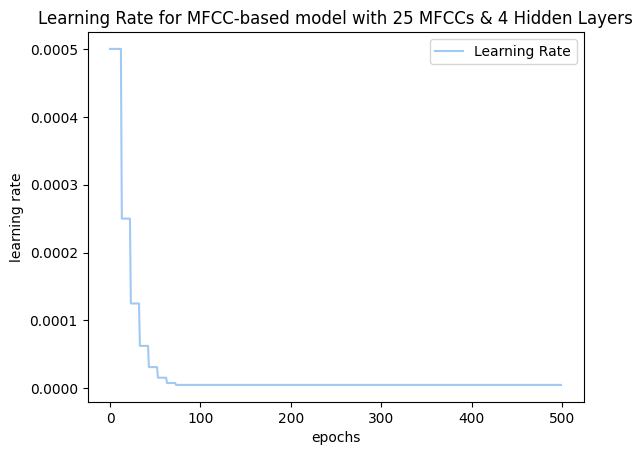

In [ ]:
learning_rate_history = large_fit_history[['lr']]
learning_rate_title = f'Learning Rate for MFCC-based model with {model_architecture}'
learning_rate_history = learning_rate_history.rename(
    columns={'lr': 'Learning Rate'})
learning_rate_history.plot(
    title=learning_rate_title, xlabel='epochs', ylabel='learning rate')
plt.show()

Now, let's plot the loss funciton of our model. We chose the sparse_categorical_crossentropy function as a loss function, because it is one of the most standard function for classification of classes, compared to binary classification

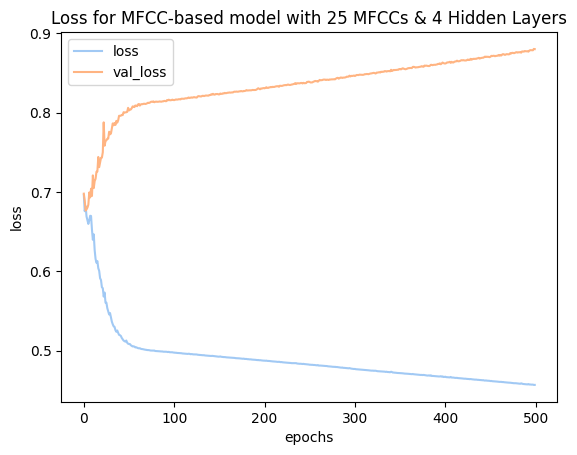

In [ ]:
loss_history_title = f'Loss for MFCC-based model with {model_architecture}'
loss_history = large_fit_history[['loss','val_loss']]
loss_history.plot(title=loss_history_title, xlabel='epochs', ylabel='loss')
plt.show()

As we can see, while the loss of the test set goes down, the loss of the validation set (in our case we use the test as the validation as well) increases. This is a sign of strong overfitting, which means our model overlearns on the training data, and does not generalize to real world use-cases. So, we are going to try a smaller model in hopes it won't happen again

### MFCC Model - Small Model
We reduce the number of MFCC features to 13, and try again

In [ ]:
filenames = metadata_df['filename']

# Create features
features = filenames.progress_apply(mfcc_feature_extractor, n_mfcc=13)
features.rename('features', inplace=True)
features_named = pd.concat([filenames, features], axis=1)
features_named.head(10)

# Create classification
classes_named = metadata_df[['filename', 'deaths_binary']]
classes_named = classes_named.rename(
  columns={'deaths_binary': 'resulted_in_deaths'})

# Create combied dataframe
features_classes = pd.merge(features_named, classes_named)
features_classes.head(10)

# train test split
features = np.array(features_classes['features'].tolist())
classes = np.array(features_classes['resulted_in_deaths'])
X_train_small_model, X_test_small_model, y_train_small_model, y_test_small_model = train_test_split(
    features, classes ,test_size=0.25, shuffle=True, stratify=classes,
    random_state=0)

# model params
input_shape = (features.shape[1],)
hidden_layers = 2
unit_scalar = 2

100%|██████████| 706/706 [00:06<00:00, 109.96it/s]


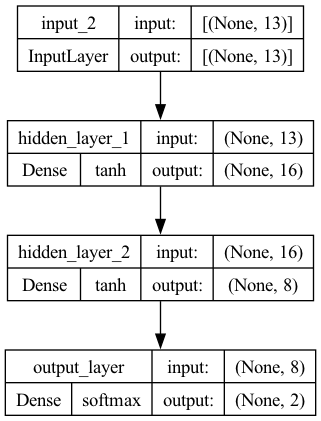

In [ ]:
# build model from configs
small_model = create_model(
    input_shape=input_shape, hidden_layers=hidden_layers,
    unit_scalar=unit_scalar)

# create a plot for out model
plot_model(small_model, show_shapes=True, show_layer_activations=True)

As we can see, the neural network is smaller, having less layers and less nodes.
Let's train this model:

In [ ]:
# params
verbosity = 0
epochs = 150

# define callbacks
reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001,
    verbose=verbosity)

earlystopping = callbacks.EarlyStopping(
    monitor="val_loss", patience=25, restore_best_weights=True,
    min_delta=0.00001, start_from_epoch=25,
    verbose=verbosity)

# fit
small_fit  = small_model.fit(
    X_train_small_model,
    y_train_small_model,
    epochs=epochs,
    validation_data=(X_test_small_model, y_test_small_model),
    callbacks=[
        earlystopping,
        reduce_lr_callback
        ],
    verbose=verbosity)

small_fit_history = pd.DataFrame(small_fit.history)
model_architecture = f'{features.shape[1]} MFCCs & {hidden_layers} Hidden Layers'
print(f'Number of Actual Epochs: {small_fit_history.shape[0]}')


Number of Actual Epochs: 78


Now, let's see the learning rate curve:

Number of Actual Epochs: 78


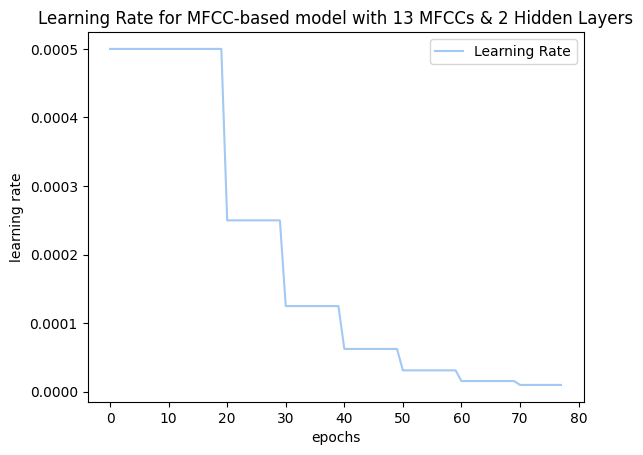

In [ ]:
small_fit_history = pd.DataFrame(small_fit.history)
model_architecture = f'{features.shape[1]} MFCCs & {hidden_layers} Hidden Layers'
print(f'Number of Actual Epochs: {small_fit_history.shape[0]}')

learning_rate_history = small_fit_history[['lr']]
learning_rate_title = f'Learning Rate for MFCC-based model with {model_architecture}'
learning_rate_history = learning_rate_history.rename(
    columns={'lr': 'Learning Rate'})
learning_rate_history.plot(
    title=learning_rate_title, xlabel='epochs', ylabel='learning rate')
plt.show()

Now, let's plot the loss and validation loss to see if we are still overfitting:

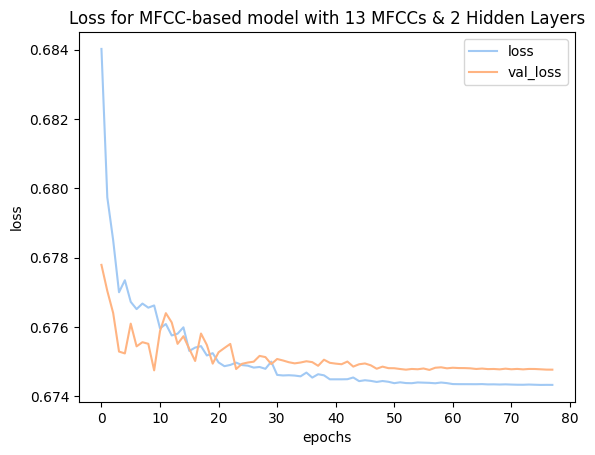

In [ ]:
loss_history_title = f'Loss for MFCC-based model with {model_architecture}'
loss_history = small_fit_history[['loss','val_loss']]
loss_history.plot(title=loss_history_title, xlabel='epochs', ylabel='loss')
plt.show()

Unlike before, the loss isn't rising, which means it's not a hard overfit. however, we can also see it's not decreasing by much

Now let's plot the accuracy over the epoches, that is, the correct guesses out of all of the data the model has made, on our training data.

We also plot val_accuracy which is validation set accuracy, and we use the test set for the validaiton here.

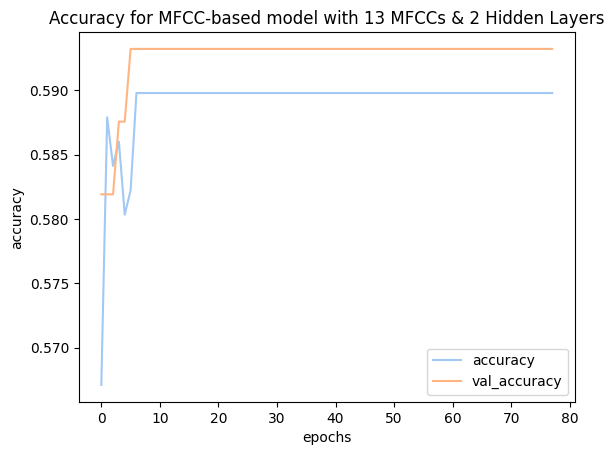

In [ ]:
accuracy_history_title = f'Accuracy for MFCC-based model with {model_architecture}'
accuracy_history = small_fit_history[['accuracy','val_accuracy']]
accuracy_history.plot(
    title=accuracy_history_title, xlabel='epochs', ylabel='accuracy')
plt.show()

In [ ]:
loss, test_accuracy = small_model.evaluate(X_test_small_model, y_test_small_model,
  verbose=0)
print("Test accuracy", test_accuracy)

Test accuracy 0.5932203531265259


as we can see we reached a total of 0.59, which means we got almost 60% of our results correctly. This number is not high enough to say the model is actually predicting anything.

Let's also take a look at the precision, recall and F1 score for better measure:

In [ ]:
small_model_y_probability = small_model.predict(X_test_small_model, verbose=0)
small_model_y_predicted = np.argmax(small_model_y_probability, axis=-1)

small_model_report = metrics.classification_report(
    y_test_small_model, small_model_y_predicted, digits=4,
    target_names=['Non-Fatal','Fatal'])
print(small_model_report)

              precision    recall  f1-score   support

   Non-Fatal     0.0000    0.0000    0.0000        72
       Fatal     0.5932    1.0000    0.7447       105

    accuracy                         0.5932       177
   macro avg     0.2966    0.5000    0.3723       177
weighted avg     0.3519    0.5932    0.4418       177



Let's display a confusion matrix of the results:

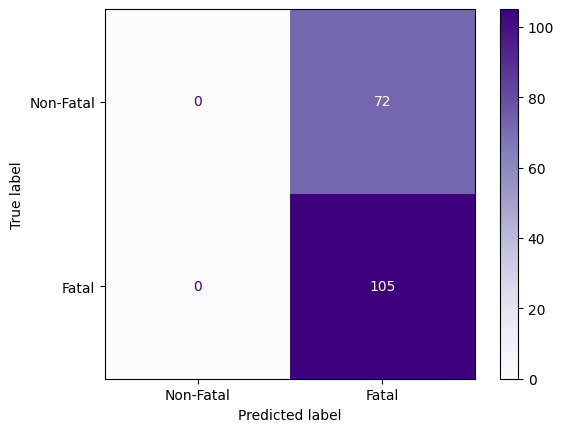

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(
    y_test_small_model, small_model_y_predicted,
    display_labels=['Non-Fatal','Fatal'],
    cmap='Purples')
plt.show()

So, it seems our model predicts virtually all the data to be fatal. Not a very sofisticated model.
Overall, our model failed to reliably predict whether or not a call was dangerous baesd on the given parameters, as can also be witnessed from this ROC curve:

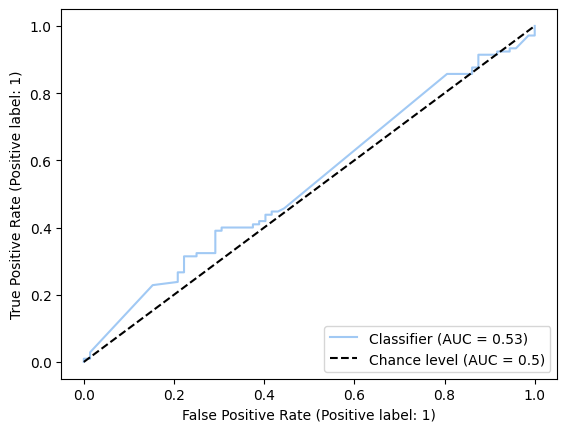

In [ ]:
metrics.RocCurveDisplay.from_predictions(
    y_test_small_model, small_model_y_probability[:, 1], plot_chance_level=True)
plt.show()

This model does marginally worse than a coin toss according to the AUC-ROC.

It's worth mentioning we also tried the above after balancing completly the labels of the calls. Unfortunately, this led to similar results.

We assume the bad results are because of lacking data - after all, we had only passed information from the audio, without any understanding of the words that were spoken during the call, which convey a lot of information. We believe that maybe incorporating this data into the model's features can boost our success rate.

## Text-based Models

#### Adding the conversation text
For this to work, we will need to chain several models. First, we would need a speech to text model.
Then, we will connect it to a language model to understand context.
Then, we will train our data on that model to classify the results

First, let's choose a speech to text model
We will try to decipher the audio as is, using four different speach to text engines: Google, Sphinx, Vosk & Whisper (engines that have public APIs).

In [ ]:
import speech_recognition as sr
from vosk import Model, KaldiRecognizer
from difflib import SequenceMatcher
import json
import timeit
from vosk import SetLogLevel
SetLogLevel(-1)


In [ ]:
r = sr.Recognizer()

def get_audio(audio_file_path, filter_noise=False):
  with sr.AudioFile(audio_file_path) as src:
    if filter_noise:
      r.adjust_for_ambient_noise(src, duration=0.5)
    return r.record(src)

def recognize_vosk(audio, model='eng_small'):
  models_path = os.path.join(cwd, 'models')
  model_path = os.path.join(models_path, 'vosk', model)

  vosk_audio = audio.get_raw_data(convert_rate=16000, convert_width=2)

  #
  model = Model(model_path)
  recognizer = KaldiRecognizer(model, 16000)
  recognizer.AcceptWaveform(vosk_audio)
  return recognizer.FinalResult()

def transcribe_file(filename, filter_noise=False):
  path = get_path_from_filename(filename)
  audio = get_audio(path, filter_noise=filter_noise)

  try:
    g = r.recognize_google(audio)
  except:
    g = "UNABLE TO RECOGNIZE"

  s = r.recognize_sphinx(audio)

  w = r.recognize_whisper(audio)

  vt = recognize_vosk(audio)
  v = json.loads(vt)['text']

  return g, s, w, v

Now, we will tag 10 results ourselves for evaluation of the models:

In [ ]:
manual_transcriptions = {
    '911_first6sec/call_8_0.wav': "um hello hello is everything okay",
    '911_first6sec/call_9_0.wav': 'yes um i need a police officer over here at whats going on',
    '911_first6sec/call_10_0.wav': "ma'am my pickup was stolen I had to go find it uhh",
    '911_first6sec/call_11_0.wav': "no ma'am i don't i don't have an emergency two police officers just at my house just now",
    '911_first6sec/call_15_0.wav': "I'm Dylon Peterson and i just killed two people",
    '911_first6sec/call_17_0.wav': "yeah we got a fire down here at on route seven right here at abington",
    '911_first6sec/call_20_0.wav': "are you out of the house yet no alright get out of the house we can't theres a",
    '911_first6sec/call_21_0.wav': "yes is this a police station yes it is may i help you yeah okay i put this is ridiculous",
    '911_first6sec/call_28_0.wav': "can you please send rescue to i think i'm",
    '911_first6sec/call_31_0.wav': "oh my god somebody is shooting at the sheriff's department at the sheriff department yes building?"
}

manual_transcriptions = pd.Series(manual_transcriptions)
manual_transcriptions = manual_transcriptions.rename('manual_transcriptions')
manual_transcriptions = pd.DataFrame(manual_transcriptions).reset_index()
manual_transcriptions = manual_transcriptions.rename({'index': 'filename'}, axis=1)

filenames = pd.Series(manual_transcriptions['filename'])

Now, we can use the transcribe_file function to get the transcriptions for each file

In [ ]:
indices = ['google', 'sphinx', 'whisper', 'vosk']

transcriptions_series = filenames.progress_apply(transcribe_file)
column_names = {
    k: v for k, v in enumerate(indices)
  }
transcriptions_list = transcriptions_series.values.tolist()
transcriptions = pd.DataFrame(transcriptions_list).rename(column_names, axis=1)

100%|██████████| 10/10 [00:39<00:00,  3.91s/it]


Let's create a separate dataframe that will include the transcription of the models for assessment and see some of the results:

In [ ]:
assessment = pd.DataFrame({"filename": filenames})
assessment = pd.concat([assessment, transcriptions], axis=1)
assessment = assessment.merge(
    manual_transcriptions, left_on='filename', right_on='filename')
assessment.head(10)

,filename,google,sphinx,whisper,vosk,manual_transcriptions
0,911_first6sec/call_8_0.wav,UNABLE TO RECOGNIZE,and while the al and then again okay go ahead,Hello. Is everything okay? On.,and now i'm now is everything okay,um hello hello is everything okay
1,911_first6sec/call_9_0.wav,UNABLE TO RECOGNIZE,he had an idea of a pound and a coil of oil an...,"Yes, I need a police officer over here. What'...",that i'm anita police officer over here the co...,yes um i need a police officer over here at wh...
2,911_first6sec/call_10_0.wav,UNABLE TO RECOGNIZE,no wonder the political had invited laugh,"Ma'am, my cat is a person. I had it offended.",now my pick up on to go find that ah,ma'am my pickup was stolen I had to go find it...
3,911_first6sec/call_11_0.wav,UNABLE TO RECOGNIZE,i'd really a man am i to have an latent he cou...,I'm gonna go to the bathroom and close the le...,remember my mom i got my house personality,no ma'am i don't i don't have an emergency two...
4,911_first6sec/call_15_0.wav,UNABLE TO RECOGNIZE,glendon beard and that is killed two people that,I'm Joan Pearson and that has killed two people.,i'm i'm down there and that it killed few people,I'm Dylon Peterson and i just killed two people
5,911_first6sec/call_17_0.wav,UNABLE TO RECOGNIZE,the little hard and long little doubt and let ...,"We've got a far down here, it's around 7, rig...",there we go too far down here at our or out th...,yeah we got a fire down here at on route seven...
6,911_first6sec/call_20_0.wav,UNABLE TO RECOGNIZE,we have our dead and now or i didn't have reac...,Are you out of the house yet? No. Or I get ou...,i get out of our now i get out of as we can't,are you out of the house yet no alright get ou...
7,911_first6sec/call_21_0.wav,UNABLE TO RECOGNIZE,whether you're completely hemmed and looking f...,"Yes, it is. Please return. Yes, it is. May he...",i can't help you okay i put is ridiculous,yes is this a police station yes it is may i h...
8,911_first6sec/call_28_0.wav,UNABLE TO RECOGNIZE,and i knew her out and adam had,Can you please send rescue to... I think I'm ...,you keep him back to to i think i'm having,can you please send rescue to i think i'm
9,911_first6sec/call_31_0.wav,UNABLE TO RECOGNIZE,so why when you hear more than that but i'd ha...,"Oh my God, so many students at this year's de...",oh look at how many shooting here for partner ...,oh my god somebody is shooting at the sheriff'...


Now, we will use difflib's SequenceMatcher to assess the results, to try and pin a number to how the models did:

In [ ]:
def similar(row, indices: list, compare_to='manual_transcriptions'):
    t = [
        SequenceMatcher(a=row[col], b=row[compare_to]).ratio()
        for col in indices
    ]
    return tuple(t)

In [ ]:
scores_series = assessment.progress_apply(similar, axis=1, indices=indices)
scores_list = scores_series.values.tolist()
scores = pd.DataFrame(scores_list).rename(column_names, axis=1)

100%|██████████| 10/10 [00:00<00:00, 1010.21it/s]


In [ ]:
print(scores.mean().sort_values(ascending=False))

whisper    0.682378
vosk       0.584759
sphinx     0.334570
google     0.053875
dtype: float64


We figured that since the audio is pretty dirty, cleaning it up could provide better results for the models. for that, we pass the results through the "adjust_for_ambient_noise" function and test the models again:

In [ ]:
transcriptions_series = filenames.progress_apply(
    transcribe_file, filter_noise=True);
transcriptions_list = transcriptions_series.values.tolist()
transcriptions = pd.DataFrame(transcriptions_list).rename(column_names, axis=1)

assessment_clean = pd.DataFrame({"filename": filenames})
assessment_clean = pd.concat([assessment_clean, transcriptions], axis=1)
assessment_clean = assessment_clean.merge(
    manual_transcriptions, left_on='filename', right_on='filename')


Let's take a look at the results:

In [ ]:
scores_clean_series = assessment_clean.progress_apply(
    similar, axis=1, indices=indices)
scores_clean_list = scores_clean_series.values.tolist()
scores_clean = pd.DataFrame(scores_clean_list).rename(column_names, axis=1)
print(scores_clean.mean().sort_values(ascending=False))

100%|██████████| 10/10 [00:00<00:00, 970.01it/s]

whisper    0.741748
vosk       0.582758
sphinx     0.319726
google     0.053875
dtype: float64


We essentially got the same ranking, with google and sphinx actually worsening as a result of the cleaning, vosk staying roughly the same and whisper improving substantially.

Because Google is unreliable in producing a transcription, we will procced with whisper and vosk and check some of the different sub-models available.

#### Vosk Analysis
Let's see the results of some of the models

In [ ]:
def transcribe_vosk(filename, filter_noise=False, models=[]):
  path = get_path_from_filename(filename)
  audio = get_audio(path, filter_noise=filter_noise)

  t = []
  for model in models:
    vt = recognize_vosk(audio, model)
    t.append(json.loads(vt)['text'])

  return tuple(t)

In [ ]:
vosk_models = ['eng_large', 'eng_small', 'vosk-model-en-us-0.22', 'vosk-model-en-us-0.42-gigaspeech']
vosk_series = filenames.progress_apply(transcribe_vosk, filter_noise=True, models=vosk_models)
vosk_column_names = {k: v for k, v in enumerate(vosk_models)}
vosk_list = vosk_series.values.tolist()
vosk_df = pd.DataFrame(vosk_list).rename(vosk_column_names, axis=1)

100%|██████████| 10/10 [03:49<00:00, 22.94s/it]


In [ ]:
assessment_vosk = pd.DataFrame({"filename": filenames})
assessment_vosk = pd.concat([assessment_vosk, vosk_df], axis=1)
assessment_vosk = assessment_vosk.merge(manual_transcriptions, left_on='filename', right_on='filename')

For assessing the results we run the algorithm "gestalt pattern matching" on the data:

In [ ]:
scores_vosk_series = assessment_vosk.progress_apply(
    similar, axis=1, indices=vosk_models)
scores_vosk_list = scores_vosk_series.values.tolist()
scores_vosk = pd.DataFrame(scores_vosk_list).rename(vosk_column_names, axis=1)
print(scores_vosk.mean().sort_values(ascending=False))

100%|██████████| 10/10 [00:00<00:00, 990.69it/s]

vosk-model-en-us-0.42-gigaspeech    0.799409
vosk-model-en-us-0.22               0.730497
eng_large                           0.703083
eng_small                           0.593164
dtype: float64


We've got some pretty good performances here from the heavy models, with the gigaspeech performing very well.

#### Whisper Analysis

In [ ]:
def transcribe_whisper(filename, filter_noise=False, models=[]):
  path = get_path_from_filename(filename)
  audio = get_audio(path, filter_noise=filter_noise)

  t = []
  for model in models:
      t.append(r.recognize_whisper(audio, model, language='english'))

  return tuple(t)

In [ ]:
filenames = pd.Series(manual_transcriptions['filename'])
whisper_models = [ 'base', 'medium', 'large']
whisper_series = filenames.progress_apply(
    transcribe_whisper, filter_noise=True, models=whisper_models)
whisper_column_names = {
    k: v for k, v in enumerate(whisper_models)
  }
whisper_list = whisper_series.values.tolist()
whisper_df = pd.DataFrame(whisper_list).rename(whisper_column_names, axis=1)

100%|█████████████████████████████████████| 2.88G/2.88G [09:39<00:00, 5.33MiB/s]
100%|██████████| 10/10 [11:58<00:00, 71.87s/it]


In [ ]:
whisper_assessment = pd.DataFrame({"filename": filenames})
whisper_assessment = pd.concat([whisper_assessment, whisper_df], axis=1)
whisper_assessment = whisper_assessment.merge(manual_transcriptions, left_on='filename', right_on='filename')
whisper_assessment

,filename,base,medium,large,manual_transcriptions
0,911_first6sec/call_8_0.wav,Hello. Hello. Is everything okay? I'm.,Hello. Hello. Is everything okay? Um. Hello. ...,Hello. Hello. Is everything okay?,um hello hello is everything okay
1,911_first6sec/call_9_0.wav,I need a police officer over here at 7. What'...,I need a police officer over here at 7th. Wha...,"Yes, I need a police officer over here at 7th...",yes um i need a police officer over here at wh...
2,911_first6sec/call_10_0.wav,"Ma'am, my kekep was born. I had to go find it.","Ma'am, my pickup was stolen. I had to go find...","Ma'am, my pickup was stolen. I had to go find...",ma'am my pickup was stolen I had to go find it...
3,911_first6sec/call_11_0.wav,I'm gonna go to the bathroom and close the le...,No ma'am I don't. I don't have an emergency. ...,"No, ma'am, I don't. I don't have an emergency...",no ma'am i don't i don't have an emergency two...
4,911_first6sec/call_15_0.wav,I'm Don Pearson and I just killed two people.,I'm Dylan Beards and that has killed two people.,I'm Dylan Peterson and I just killed two people.,I'm Dylon Peterson and i just killed two people
5,911_first6sec/call_17_0.wav,"We've got a far down here, it's on Route 7, r...","We've got a fire down here on Route 7, right ...","We've got a fire down here on Route 7, right ...",yeah we got a fire down here at on route seven...
6,911_first6sec/call_20_0.wav,You're out of the house yet? No. Or I get out...,"Are you out of the house yet? No. All right, ...","Are you out of the house yet? No. All right, ...",are you out of the house yet no alright get ou...
7,911_first6sec/call_21_0.wav,"Yes, it is a police station. Yes, it is. May ...","Yes, is this the police station? Yes it is, m...","Yes, is this the police station? Yes, it is. ...",yes is this a police station yes it is may i h...
8,911_first6sec/call_28_0.wav,Please send a rescue to I think I'm having a,police and rescue to. I think I'm having.,Please send rescue to .,can you please send rescue to i think i'm
9,911_first6sec/call_31_0.wav,"Oh my God, some of these children that they s...","Oh my god, so many students at the sheriff's ...","Oh my God, somebody's shooting at the Sheriff...",oh my god somebody is shooting at the sheriff'...


In [ ]:
whisper_scores_series = whisper_assessment.progress_apply(
    similar, axis=1, indices=whisper_models)
whisper_scores_list = whisper_scores_series.values.tolist()
whisper_scores = pd.DataFrame(whisper_scores_list).rename(
    whisper_column_names, axis=1)
print(whisper_scores.mean().sort_values(ascending=False))

100%|██████████| 10/10 [00:00<00:00, 1071.34it/s]

large     0.816793
medium    0.782562
base      0.741748
dtype: float64


Interestingly the medium model performed better than the large model, with performance roughly equivalent to the vosk gigaspeech model.

#### Timing
Let's compare their time to predict next, to see if they will be viable in a large environment.

In [ ]:
def time_transcribe(filename, transcriber, models):
  timer = timeit.Timer(
    lambda: transcriber(filename, filter_noise=True, models=models))
  return timer.timeit(1)

In [ ]:
whisper_models = ['medium']
whisper_time = filenames.progress_apply(
    time_transcribe, transcriber=transcribe_whisper, models=whisper_models)

100%|██████████| 10/10 [01:01<00:00,  6.16s/it]


In [ ]:
transcribe_time = pd.DataFrame(filenames)
transcribe_time['whisper_time'] = whisper_time

As we can see it took around 2-4 seconds per sample, except for the first one, which encludes the time it took to load the model to memory.

This can be further reduced by using a gpu, so it seems viable for a real time model.

In [ ]:
vosk_models = ['vosk-model-en-us-0.42-gigaspeech']
vosk_time = filenames.progress_apply(
    time_transcribe, transcriber=transcribe_vosk, models=vosk_models)

100%|██████████| 10/10 [01:45<00:00, 10.58s/it]


In [ ]:
transcribe_time = pd.DataFrame(filenames)
transcribe_time['vosk_time'] = vosk_time

Each transcription using vosk took dozens of second to transcribe - meaning it is not viable to a real time application, 
so we drop it, and continue with *whisper* as the speech to text engine.

In [ ]:
metadata_df = df_clean
filenames = pd.Series(metadata_df['filename'].unique())
whisper_models = ['medium']
whisper_series = filenames.progress_apply(
    transcribe_whisper, filter_noise=True, models=whisper_models)
whisper_column_names = {
    k: v for k, v in enumerate(whisper_models)
  }
whisper_list = whisper_series.values.tolist()
whisper_df = pd.DataFrame(whisper_list).rename(whisper_column_names, axis=1)

100%|██████████| 706/706 [55:09<00:00,  4.69s/it]  


In [ ]:
path_to_transcr = os.path.join(calls_dir, '911_first6sec', 'transcriptions')

In [ ]:
filenames = filenames.rename('filename')
filenames_df = pd.DataFrame(filenames)
transcriptions_df = pd.concat([filenames, whisper_df], axis=1)
transcriptions_df.head(10)
transcriptions_df.to_csv(path_to_transcr, index=False)

### Training the text based model

We will now try to take the text that the speech to text model spit out, and use it to predict whether or not a 911 call is dangerous.
For that, we will try using a text based CNN model, based on [[Mandelbaum and Shalev, 2016]](https://arxiv.org/pdf/1610.08229.pdf) using a random embedding, that is, the represantation of words as vectors.

In [ ]:
from sentence_transformers import SentenceTransformer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

# Setup
pd.options.mode.chained_assignment = None  # default='warn'

Now, let's take our transcriptions, and use them to train a model, that will be able to predict whether the caller is in danger in real time.

In [ ]:
metadata_df = df_clean

# create the model data
model_data = metadata_df[['filename', 'deaths_binary']].reset_index(drop=True)
transcriptions = pd.read_csv(path_to_transcr)
model_data['transcription'] = transcriptions['medium']

In [ ]:
transcriptions['len'] = model_data['transcription'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(transcriptions.len.mean()))
print("max length of sentence: " + str(transcriptions.len.max()))
print("std dev length of sentence: " + str(transcriptions.len.std()))

mean length of sentence: 15.939093484419264
max length of sentence: 33
std dev length of sentence: 5.564372613450612


Let's tokenize the texts and turn them to feature vectors - we will split the text to words, then represent each word as a token

In [ ]:
sequence_length = int(transcriptions.len.max())
max_features = 20000

# create features
tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.analyzer = text_to_word_sequence
model_data = model_data.dropna()
tokenizer.fit_on_texts(model_data['transcription'].values)
features = tokenizer.texts_to_sequences(model_data['transcription'].values)
features = pad_sequences(features, sequence_length)
model_data['vectorization'] = pd.Series(features.tolist())

# create classes
classes = pd.get_dummies(model_data['deaths_binary'], dtype='uint8').values
model_data['classes'] = pd.Series(classes.tolist())

model_data.drop('deaths_binary', inplace=True, axis=1, errors='ignore')


Split to train and test:

In [ ]:
X_train_text_emb, X_test_text_emb, y_train_text_emb, y_test_text_emb = train_test_split(
    features, classes, test_size=0.25, shuffle=True, stratify=classes,
    random_state=0
    )

Let's build the CNN model:

In [ ]:
def cnn_model(embedding_dim, num_filters, dropout_rate=0.5,
              loss='categorical_crossentropy',  optimizer_name='Adam',
              learning_rate=0.001):
  #
  inputs = layers.Input(shape=(sequence_length,), dtype='int32')

  #
  emb_layr = layers.Embedding(
      input_dim=max_features, output_dim=embedding_dim, input_length=sequence_length)(inputs)

  #
  reshape = layers.Reshape((sequence_length, embedding_dim, 1))(emb_layr)

  #
  conv_0 = layers.Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_0 = layers.MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)

  #
  conv_1 = layers.Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_1 = layers.MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1)

  #
  conv_2 = layers.Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_2 = layers.MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2)

  #
  concatenated_tensor = layers.Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
  flatten = layers.Flatten()(concatenated_tensor)

  #
  dropout = layers.Dropout(dropout_rate)(flatten)

  #
  output = layers.Dense(units=2, activation='softmax')(dropout)

  opt = getattr(optimizers, optimizer_name)
  tm = models.Model(inputs=inputs, outputs=output)
  tm.compile(loss=loss, optimizer=opt(learning_rate), metrics=['accuracy'])

  return tm

Let's see the model's shape:

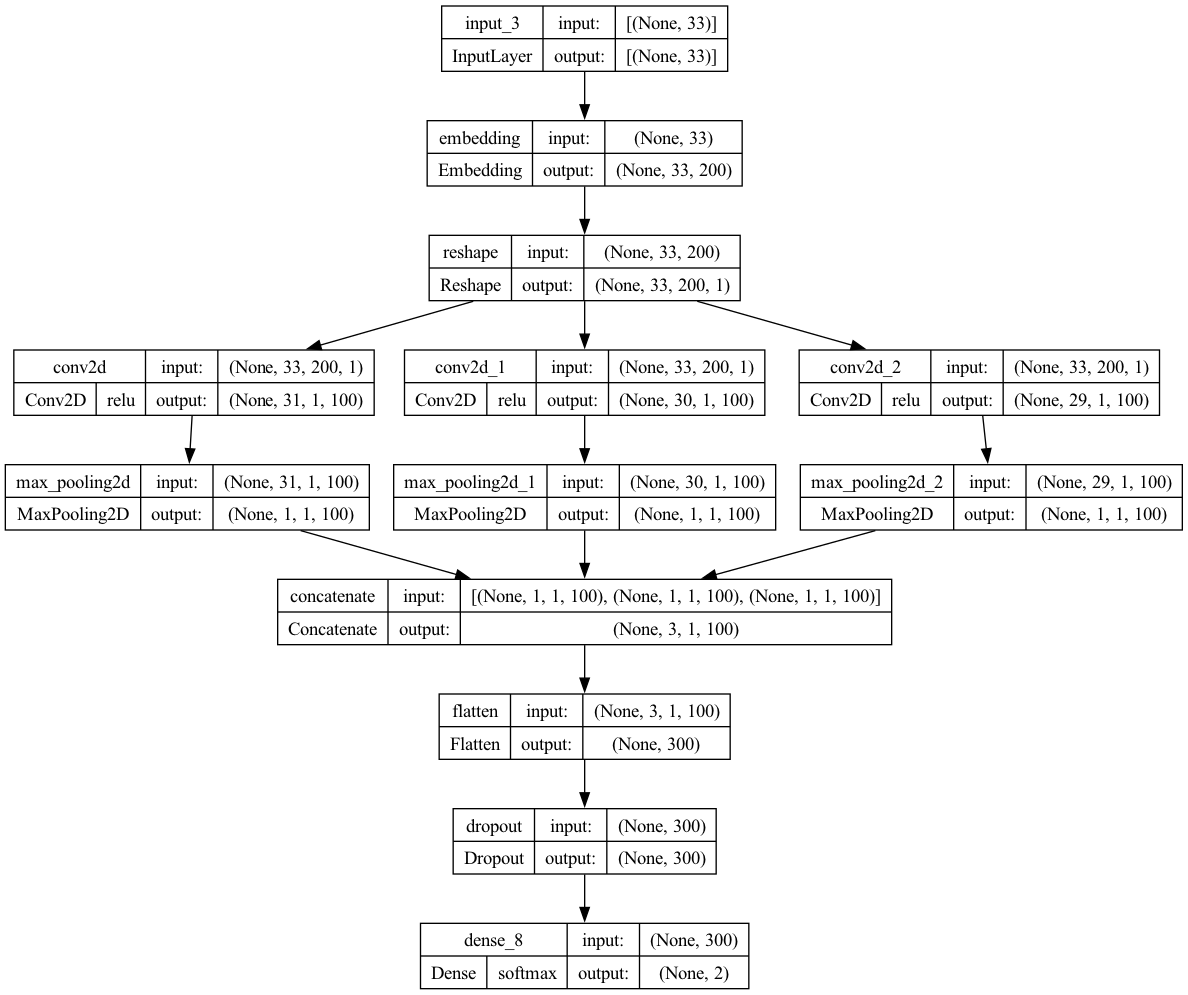

In [ ]:
embedding_dim = 200
num_filters = 100

text_model = cnn_model(embedding_dim, num_filters, learning_rate=0.001)
plot_model(text_model, show_shapes=True, show_layer_activations=True)

In [ ]:
verbosity = 0
batch_size = 32
epochs = 50

# define callbacks
reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001,
    verbose=verbosity)

earlystopping = callbacks.EarlyStopping(
    monitor="val_loss",
    restore_best_weights=True,
    min_delta=0.001,
    patience=10,
    start_from_epoch=25,
    verbose=verbosity)

text_history = text_model.fit(
    X_train_text_emb,
    y_train_text_emb,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_text_emb, y_test_text_emb),
    callbacks=[
        reduce_lr_callback,
        earlystopping
        ],
    verbose=verbosity)

Lets assess this model:

In [ ]:
text_fit_history = pd.DataFrame(text_history.history)
print(f'Number of Actual Epochs: {text_fit_history.shape[0]}')

Number of Actual Epochs: 37


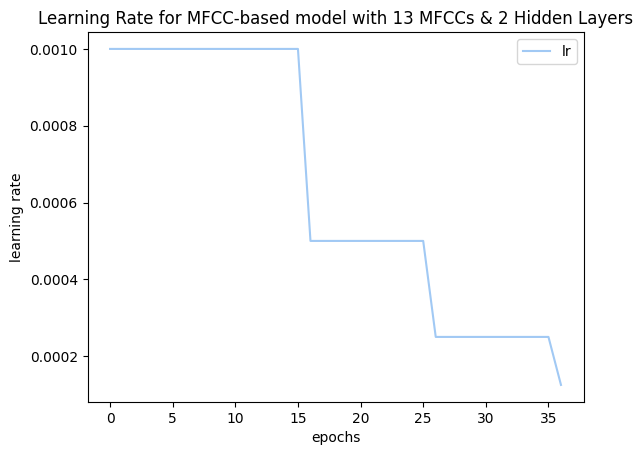

In [ ]:
learning_rate_history = text_fit_history[['lr']]
learning_rate_history.plot(
    title=learning_rate_title, xlabel='epochs', ylabel='learning rate')
plt.show()

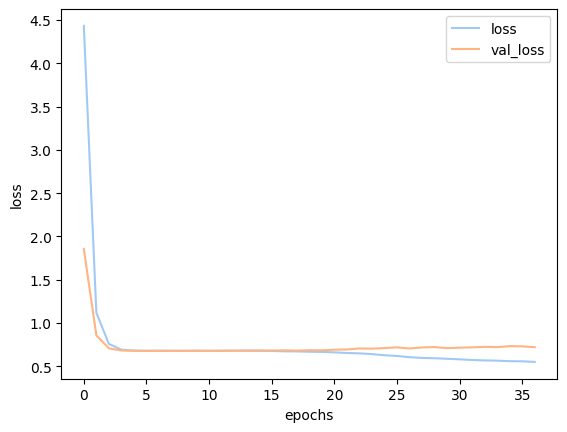

In [ ]:
loss_history = text_fit_history[['loss','val_loss']]
loss_history.plot(title='', xlabel='epochs', ylabel='loss')
plt.show()

We can see that the loss mehtod converge nicely, with no overfitting apparent overfitting.

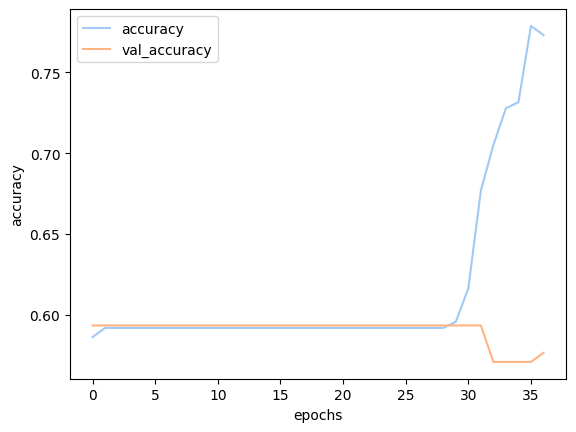

In [ ]:
accuracy_history = text_fit_history[['accuracy','val_accuracy']]
accuracy_history.plot(
    title='', xlabel='epochs', ylabel='accuracy')
plt.show()

The accuracy is pretty steady in the begging, with the accuracy of the training set improving around the 27th epoch and the validation accuracy jumping a bit around the 32th epoch, which is where we could have optimally opted out.

In [ ]:
# create assessment values
y_probability = text_model.predict(X_test_text_emb, verbose=0)
y_test_binary = np.argmax(y_test_text_emb, axis=-1)
y_predicted_binary = np.argmax(y_probability, axis=-1)

In [ ]:
test_accuracy = text_model.evaluate(X_test_text_emb, y_test_text_emb, verbose=0)
print(f'Test loss: {test_accuracy[0]}')
print(f'Test Accuracy: {test_accuracy[1]}')

Test loss: 0.7062585949897766
Test Accuracy: 0.5932203531265259


A test accuracy of almost 60 percent is similar to the small MFCC model and not too bad, on the surface better than a coin flip. Let's look over some more assessment:

In [ ]:
small_model_report = metrics.classification_report(
    y_test_binary, y_predicted_binary, digits=4,
    target_names=['Non-Fatal','Fatal'])
print(small_model_report)

              precision    recall  f1-score   support

   Non-Fatal     0.0000    0.0000    0.0000        72
       Fatal     0.5932    1.0000    0.7447       105

    accuracy                         0.5932       177
   macro avg     0.2966    0.5000    0.3723       177
weighted avg     0.3519    0.5932    0.4418       177



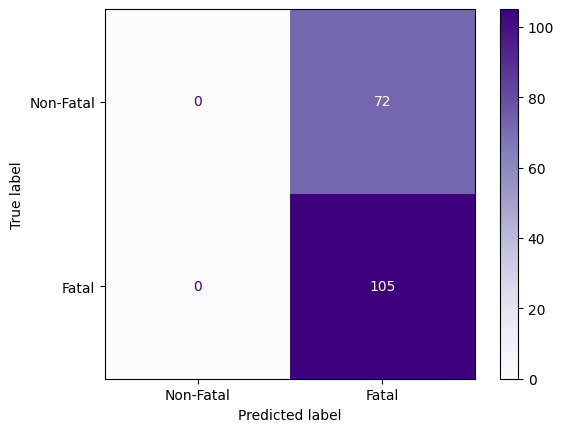

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(
    y_test_binary, y_predicted_binary,
    display_labels=['Non-Fatal','Fatal'],
    cmap='Purples')
plt.show()

Sadly we can see that the model has decided to go for the safe route and label everything a fatal, So the accuracy which we've seen before is just the skew of the Fatal examples in the set when compared to the Non-Fatal.

Let's look over the auc-roc to see if this was indeed mindless tagging.

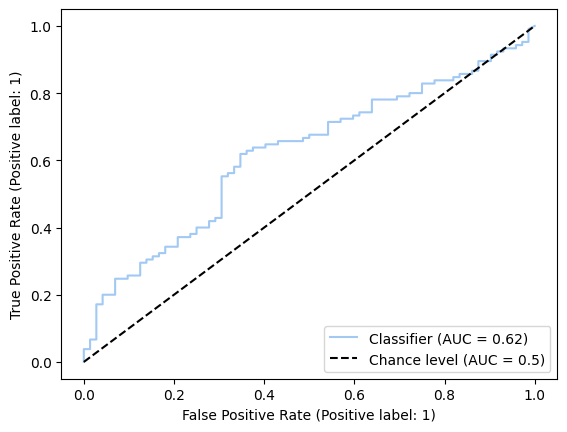

In [ ]:
metrics.RocCurveDisplay.from_predictions(
    y_test_binary, y_probability[:, 1], plot_chance_level=True)
plt.show()

This is actually quite encouraging! the model has made it's true positive tagging with a much higher certainty than in previous models, implying that this model has indeed learned something constructive, even if not at the level of definitiveness that we would want.

## In conclusion
We started this project by exploring the audio and tabular data that we've got, seeing how the different parameters were distributed, 
and used what we learned to try and create a model to detect dangerous 911 calls. after the initial model of audio data didn't work, we have added a model that translates the speech to text, and used a language model to try and give meaning to the words, and infer from that. 
Unfortunately, we were unable to create a model that correctly predicts what we set out to do, but we gave it all wev'e got - along the way we learned a lot about the world of data science, and truly enjoyed the process.